In [15]:
import os, random, time
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import label_binarize
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Dense, MaxPooling2D
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from pandas.plotting import table

In [16]:
print("GPUs:", tf.config.list_physical_devices('GPU'))
seed = 42

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Detection

In [17]:
# assign paths & params
base_dir   = '/kaggle/input/full-stego-set/stegoimagesdataset'
train_dir  = os.path.join(base_dir, 'plain/train')
val_dir    = os.path.join(base_dir, 'plain/val')
test_dir   = os.path.join(base_dir, 'plain/test')
base64_enc = os.path.join(base_dir, 'base64_encoding/test')
zip_enc    = os.path.join(base_dir, 'zip_encoding/test')

AUTOTUNE   = tf.data.AUTOTUNE
classes    = ['clean', 'stego']
batch_size = 32
label_map_detect = {
    'clean': 0,
    'stego': 1
}

# high-pass kernel (laplacian)
hp_kernel = tf.constant([[0, -1, 0],
                         [-1, 4, -1],
                         [0, -1, 0]], tf.float32)
hp_kernel = tf.reshape(hp_kernel, [3,3,1,1])

# get paths and labels
def get_paths_and_labels(target_dir, classes):
    paths, labels = [], []
    for i, cls in enumerate(classes):
        for file in os.listdir(os.path.join(target_dir, cls)):
            paths.append(os.path.join(target_dir, cls, file))
            labels.append(i)
    return paths, np.array(labels)

# resize + HPF + simple augmentation
def preprocess(path, label, is_training):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    if is_training:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
    img = tf.cast(img, tf.float32) / 255.0  
    gray     = tf.image.rgb_to_grayscale(img)    
    residual = tf.nn.conv2d(gray[None], hp_kernel, strides=1, padding='SAME')[0]
    img_hp   = tf.concat([img, residual], axis=-1)
    return img_hp, label

# mini-VGG
def build_mini_vgg(input_shape=(256,256,4)):
    m = Sequential([
        Input(shape=input_shape),
        # blok 1
        Conv2D(32,3,activation='relu',padding='same'), 
        Conv2D(32,3,activation='relu',padding='same'),
        MaxPooling2D(2),
        
        # blok 2
        Conv2D(64,3,activation='relu',padding='same'), 
        Conv2D(64,3,activation='relu',padding='same'),
        MaxPooling2D(2),
        
        # blok 3
        Conv2D(128,3,activation='relu',padding='same'), 
        Conv2D(128,3,activation='relu',padding='same'),
        MaxPooling2D(2),

        # fc
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return m

def evaluate_and_report(model, dataset, label_map, dataset_name="Dataset"):
    # Evaluate model
    loss, acc = model.evaluate(dataset, verbose=1)
    print(f"\n{dataset_name} performance → Loss: {loss:.4f}, Accuracy: {acc:.4f}")

    # Collect true labels & predicted probs
    y_true, y_probs = [], []
    for x_batch, y_batch in dataset:
        probs = model.predict(x_batch, verbose=0)[:, 0]
        y_probs.extend(probs.tolist())
        y_true.extend(y_batch.numpy().tolist())

    # Binarize predictions
    y_pred = [1 if p >= 0.5 else 0 for p in y_probs]

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Classification Report
    report_dict = classification_report(
        y_true, y_pred, 
        target_names=list(label_map.keys()), 
        output_dict=True
    )
    report_df = pd.DataFrame(report_dict).transpose()

    # === Plot Classification Report + Confusion Matrix side by side ===
    fig = plt.figure(figsize=(14, 5))
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 1.2])

    # Left side: Classification Report as table
    ax0 = fig.add_subplot(gs[0])
    ax0.axis("off")
    tbl = table(ax0, report_df.round(3), loc="center", cellLoc="center")
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9)
    tbl.scale(1.2, 1.2)
    ax0.set_title(f"{dataset_name} - Classification Report")

    # Right side: Confusion Matrix Heatmap
    ax1 = fig.add_subplot(gs[1])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(label_map.keys()),
                yticklabels=list(label_map.keys()),
                ax=ax1)
    ax1.set_xlabel("Predicted Label")
    ax1.set_ylabel("True Label")
    ax1.set_title(f"{dataset_name} - Confusion Matrix")

    plt.tight_layout()
    plt.show()

    # === ROC Curve & AUC ===
    fpr, tpr, thresh = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({dataset_name})')
    plt.legend()
    plt.show()

    # Return key metrics
    accuracy  = report_dict["accuracy"]
    precision = report_dict["weighted avg"]["precision"]
    recall    = report_dict["weighted avg"]["recall"]
    f1_score  = report_dict["weighted avg"]["f1-score"]

    return accuracy, precision, recall, f1_score, roc_auc

I0000 00:00:1762734008.096156      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [18]:
# create datasets
train_paths, train_labels = get_paths_and_labels(train_dir, classes)
val_paths,   val_labels   = get_paths_and_labels(val_dir, classes)
test_paths, test_labels = get_paths_and_labels(test_dir, classes)
base64_paths, base64_labels = get_paths_and_labels(base64_enc, classes)
zip_paths, zip_labels = get_paths_and_labels(zip_enc, classes)

train_ds = (tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    .shuffle(len(train_paths))
    .map(lambda p,l: preprocess(p,l,True), num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE)
)

val_ds = (tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
    .map(lambda p,l: preprocess(p,l,False), num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE)
)

test_ds = (tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
    .map(lambda p,l: preprocess(p,l,False), num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE)
)

base64_ds = (tf.data.Dataset.from_tensor_slices((base64_paths, base64_labels))
    .map(lambda p,l: preprocess(p,l,False), num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE)
)

zip_ds = (tf.data.Dataset.from_tensor_slices((zip_paths, zip_labels))
    .map(lambda p,l: preprocess(p,l,False), num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE)
)

In [19]:
for x, y in test_ds.take(1):
    print("Batch image shape:", x.shape)

Batch image shape: (32, 256, 256, 4)


In [20]:
model = build_mini_vgg()
model.summary()

# Compile & callbacks
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

cbs = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('mini_vgg_hp_bin.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 303,937 (1.16 MB)

 Trainable params: 303,937 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


I0000 00:00:1759489005.315569      98 service.cc:148] XLA service 0x7fcb7c1074e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759489005.317203      98 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759489005.915087      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/500 ━━━━━━━━━━━━━━━━━━━━ 35s 72ms/step - accuracy: 0.7031 - loss: 0.6848   

I0000 00:00:1759489015.252940      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7515 - loss: 0.5785
Epoch 1: val_loss improved from inf to 0.56358, saving model to mini_vgg_hp_bin.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 118s 210ms/step - accuracy: 0.7514 - loss: 0.5785 - val_accuracy: 0.7500 - val_loss: 0.5636 - learning_rate: 1.0000e-04
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7520 - loss: 0.5655
Epoch 2: val_loss improved from 0.56358 to 0.56302, saving model to mini_vgg_hp_bin.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 90s 181ms/step - accuracy: 0.7520 - loss: 0.5655 - val_accuracy: 0.7500 - val_loss: 0.5630 - learning_rate: 1.0000e-04
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7444 - loss: 0.5711
Epoch 3: val_loss did not improve from 0.56302
500/500 ━━━━━━━━━━━━━━━━━━━━ 90s 180ms/step - accuracy: 0.7444 - loss: 0.5710 - val_accuracy: 0.7500 - val_loss: 0.5643 - learning_rate: 1.0000e-04
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7474 - loss

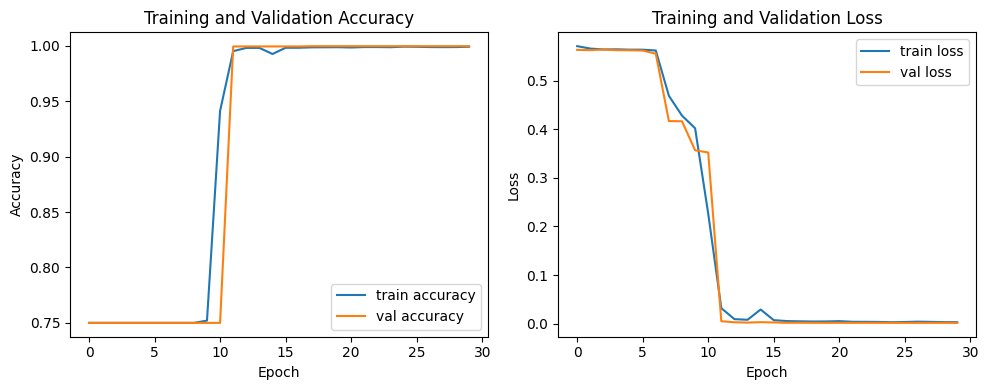

In [7]:
# Train
start_time = time.time()
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=cbs
)
duration = time.time() - start_time
print(f"Training completed in {duration:.2f} seconds ({duration/60:.2f} minutes)")

# Plot Accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


=== Evaluating on Test Set ===
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 139ms/step - accuracy: 0.9998 - loss: 0.0010

Test Set performance → Loss: 0.0008, Accuracy: 0.9998


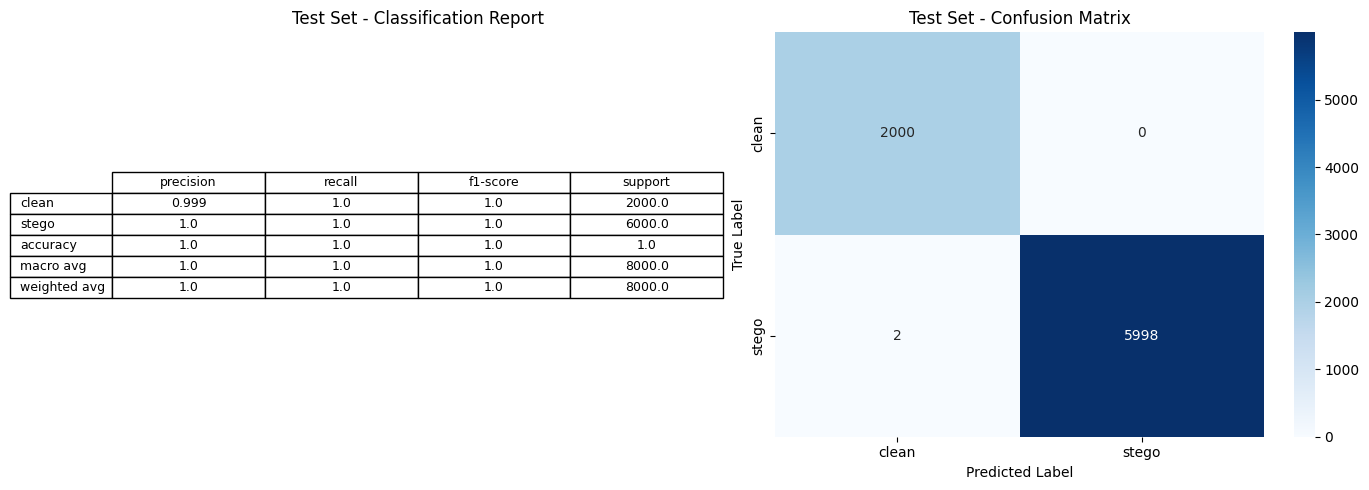

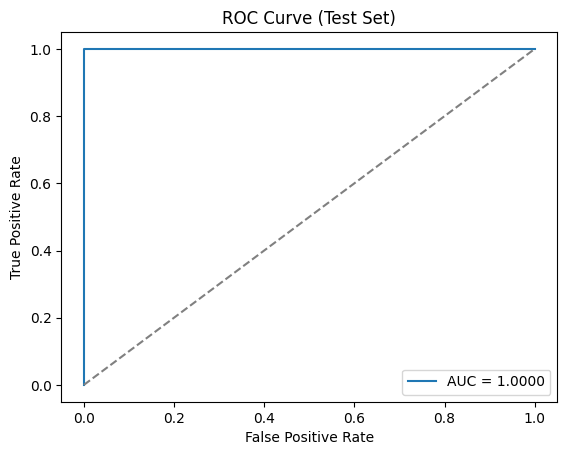


=== Evaluating on Base64 Set ===
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 139ms/step - accuracy: 0.9998 - loss: 9.6739e-04

Base64 Set performance → Loss: 0.0008, Accuracy: 0.9998


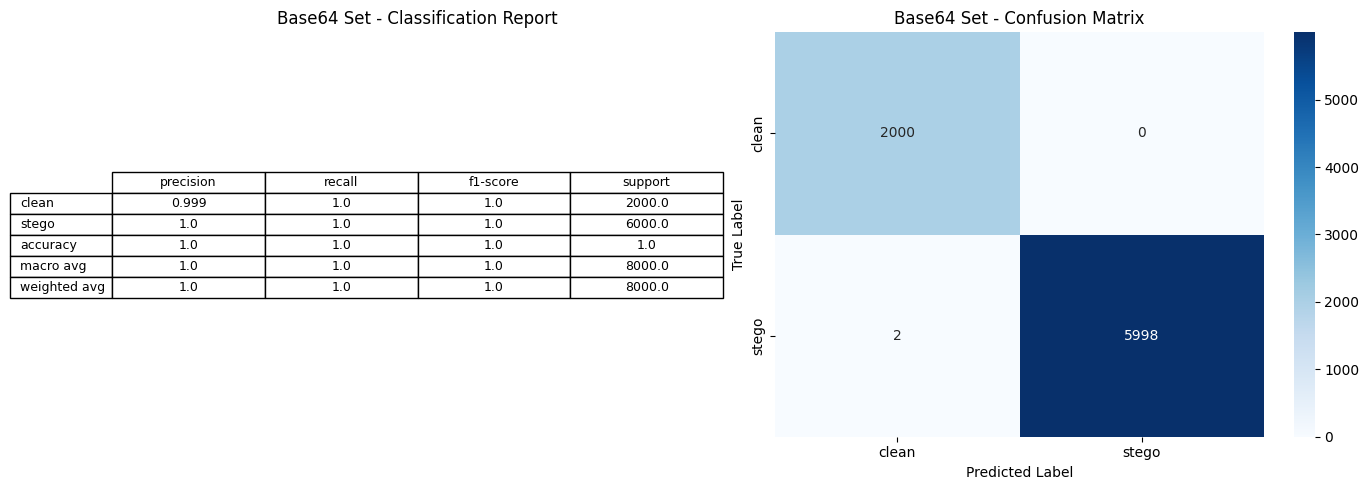

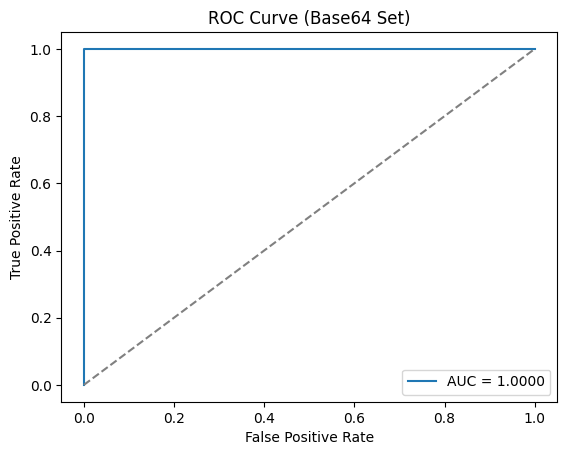


=== Evaluating on Zip Set ===
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - accuracy: 1.0000 - loss: 7.1644e-04

Zip Set performance → Loss: 0.0003, Accuracy: 1.0000


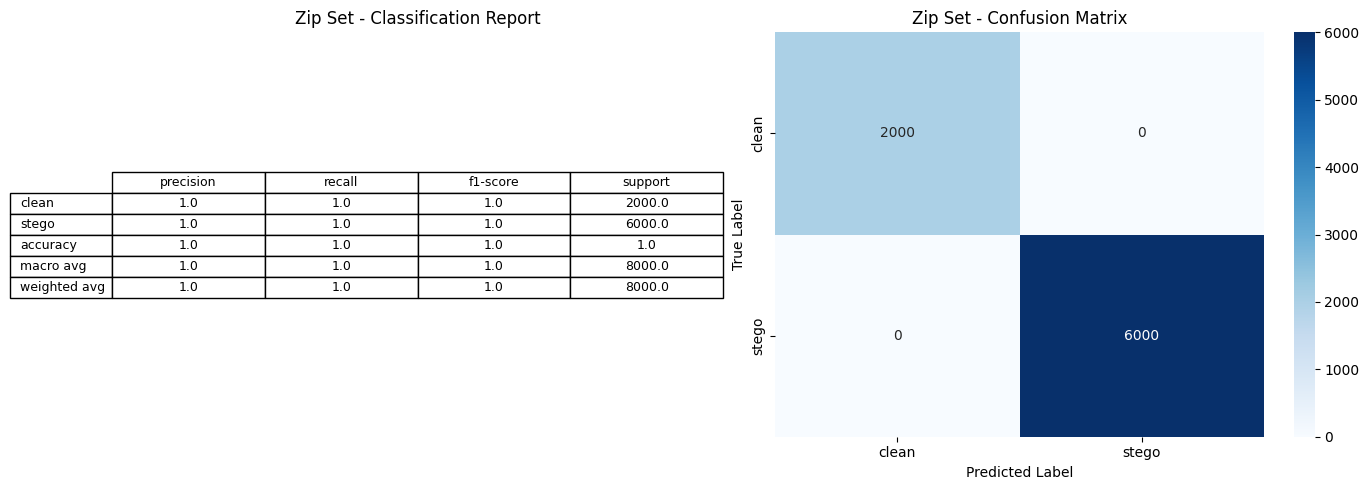

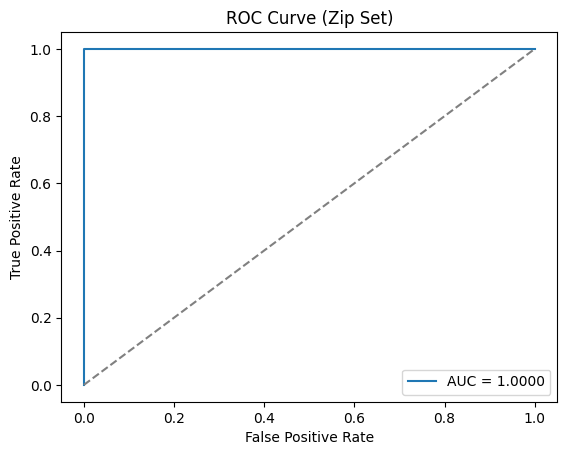

In [8]:
datasets = [
    ("Test Set",   test_ds,   test_paths,   test_labels),
    ("Base64 Set", base64_ds, base64_paths, base64_labels),
    ("Zip Set",    zip_ds,    zip_paths,    zip_labels),
]

metrics_results = {}

for name, ds, paths, labels in datasets:
    print(f"\n=== Evaluating on {name} ===")
    metrics_results[name] = evaluate_and_report(model, ds, label_map_detect, dataset_name=name)

# Classification

In [4]:
# Assign params
label_map_cs = {
    'clean': 0,
    'eth': 1,
    'url': 2,
    'ps': 3,
    'html': 4,
    'js': 5,
}

class_names = [
    'clean',
    'ethereum payload',
    'url payload',
    'powershell payload',
    'html payload',
    'javascript payload',
]

def get_paths_and_labels_class_task(target_dir, label_map):
    classes = ['clean', 'stego']
    paths, labels = [], []
    for cls in classes:
        folder = os.path.join(target_dir, cls)
        for file in os.listdir(folder):
            full_path = os.path.join(folder, file)
            paths.append(full_path)
            if cls == 'clean':
                labels.append(label_map['clean'])
            else:
                found = False
                for key in label_map:
                    if key != 'clean' and key in file:
                        labels.append(label_map[key])
                        found = True
                        break
                if not found:
                    raise ValueError(f"File not found: {file}")
    return paths, np.array(labels)

# mini-VGG
def build_mini_vgg_cs(input_shape=(256,256,4), num_classes=6):
    m = Sequential([
        Input(shape=input_shape),

        # blok 1
        Conv2D(32,3,activation='relu',padding='same'), 
        Conv2D(32,3,activation='relu',padding='same'),
        MaxPooling2D(2),
        
        # blok 2
        Conv2D(64,3,activation='relu',padding='same'), 
        Conv2D(64,3,activation='relu',padding='same'),
        MaxPooling2D(2),
        
        # blok 3
        Conv2D(128,3,activation='relu',padding='same'), 
        Conv2D(128,3,activation='relu',padding='same'),
        MaxPooling2D(2),

        # fc
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return m

def evaluate_multiclass_model(model, dataset, label_map, class_names, dataset_name="Dataset", verbose=1):
     # --- Evaluate langsung di dataset
    loss, acc = model.evaluate(dataset, verbose=verbose)
    print(f"\n{dataset_name} performance → Loss: {loss:.4f}, Accuracy: {acc:.4f}")

    # --- Predict on dataset
    y_true, y_probs, y_pred = [], [], []
    for x_batch, y_batch in dataset:
        probs = model.predict(x_batch, verbose=0)
        preds = tf.argmax(probs, axis=1)
        y_probs.extend(probs)
        y_pred.extend(preds.numpy().tolist())
        y_true.extend(y_batch.numpy().tolist())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    # --- Confusion Matrix & Classification Report
    cm = confusion_matrix(y_true, y_pred)
    report_dict_cs = classification_report(
        y_true, y_pred, target_names=list(label_map.keys()), output_dict=True
    )
    report_df = pd.DataFrame(report_dict_cs).transpose().round(3)

    # --- Plot side by side (Report kiri, CM kanan)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Left: Classification Report (table)
    axes[0].axis('off')
    table = axes[0].table(cellText=report_df.values,
                          rowLabels=report_df.index,
                          colLabels=report_df.columns,
                          cellLoc='center',
                          loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.2)
    axes[0].set_title(f"{dataset_name} - Classification Report")

    # Right: Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(label_map.keys()),
                yticklabels=list(label_map.keys()),
                ax=axes[1])
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')
    axes[1].set_title(f"{dataset_name} - Confusion Matrix")

    plt.tight_layout()
    plt.show() 

    # --- ROC Curve per class (grid otomatis)
    n_classes = len(class_names)
    y_bin = label_binarize(y_true, classes=list(range(n_classes)))

    n_cols = 3
    n_rows = int(np.ceil(n_classes / n_cols))
    fig_cs, axes_cs = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes_cs = axes_cs.ravel()

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        axes_cs[i].plot(fpr, tpr, color='orange', lw=2,
                        label=f'ROC curve (area = {roc_auc:.3f})')
        axes_cs[i].plot([0, 1], [0, 1], '--', color='navy', lw=1)
        axes_cs[i].set_xlim([0.0, 1.0])
        axes_cs[i].set_ylim([0.0, 1.05])
        axes_cs[i].set_xlabel('False Positive Rate')
        axes_cs[i].set_ylabel('True Positive Rate')
        axes_cs[i].set_title(f'({chr(97+i)}) {class_names[i]}')
        axes_cs[i].legend(loc='lower right', fontsize=8)

    # Kosongkan axes jika grid lebih banyak dari jumlah kelas
    for j in range(i+1, len(axes_cs)):
        axes_cs[j].axis('off')

    plt.tight_layout()
    plt.show()

    # --- Return metrics utama
    accuracy_cs  = report_dict_cs["accuracy"]
    precision_cs = report_dict_cs["weighted avg"]["precision"]
    recall_cs    = report_dict_cs["weighted avg"]["recall"]
    f1_score_cs  = report_dict_cs["weighted avg"]["f1-score"]

    return loss, acc, precision_cs, recall_cs, f1_score_cs

In [5]:
# create datasets
train_paths_cs, train_labels_cs = get_paths_and_labels_class_task(train_dir, label_map_cs)
val_paths_cs,   val_labels_cs   = get_paths_and_labels_class_task(val_dir, label_map_cs)
test_paths_cs, test_labels_cs = get_paths_and_labels_class_task(test_dir, label_map_cs)
base64_paths_cs, base64_labels_cs = get_paths_and_labels_class_task(base64_enc, label_map_cs)
zip_paths_cs, zip_labels_cs = get_paths_and_labels_class_task(zip_enc, label_map_cs)

train_ds_cs = (tf.data.Dataset.from_tensor_slices((train_paths_cs, train_labels_cs))
    .shuffle(len(train_paths_cs))
    .map(lambda p,l: preprocess(p,l,True), num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE)
)

val_ds_cs = (tf.data.Dataset.from_tensor_slices((val_paths_cs, val_labels_cs))
    .map(lambda p,l: preprocess(p,l,False), num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE)
)

test_ds_cs = (tf.data.Dataset.from_tensor_slices((test_paths_cs, test_labels_cs))
    .map(lambda p,l: preprocess(p,l,False), num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE)
)

base64_ds_cs = (tf.data.Dataset.from_tensor_slices((base64_paths_cs, base64_labels_cs))
    .map(lambda p,l: preprocess(p,l,False), num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE)
)

zip_ds_cs = (tf.data.Dataset.from_tensor_slices((zip_paths_cs, zip_labels_cs))
    .map(lambda p,l: preprocess(p,l,False), num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE)
)

In [7]:
model_cs = build_mini_vgg_cs()
model_cs.summary()

# Compile & callbacks
model_cs.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cbs = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('mini_vgg_hp_cs.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,582 (1.16 MB)

 Trainable params: 304,582 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60


I0000 00:00:1759499733.906824      72 service.cc:148] XLA service 0x7f41c0110600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759499733.907469      72 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759499734.491107      72 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/500 ━━━━━━━━━━━━━━━━━━━━ 35s 71ms/step - accuracy: 0.1328 - loss: 1.7873   

I0000 00:00:1759499743.983145      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.2458 - loss: 1.7742
Epoch 1: val_loss improved from inf to 1.76990, saving model to mini_vgg_hp_cs.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 120s 213ms/step - accuracy: 0.2458 - loss: 1.7742 - val_accuracy: 0.2500 - val_loss: 1.7699 - learning_rate: 1.0000e-04
Epoch 2/60
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.2497 - loss: 1.7707
Epoch 2: val_loss improved from 1.76990 to 1.76772, saving model to mini_vgg_hp_cs.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 90s 180ms/step - accuracy: 0.2497 - loss: 1.7707 - val_accuracy: 0.2500 - val_loss: 1.7677 - learning_rate: 1.0000e-04
Epoch 3/60
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.2594 - loss: 1.7482
Epoch 3: val_loss improved from 1.76772 to 1.24975, saving model to mini_vgg_hp_cs.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 90s 180ms/step - accuracy: 0.2594 - loss: 1.7481 - val_accuracy: 0.4205 - val_loss: 1.2497 - learning_rate: 1.0000e-04
Epoch 4/60
500/500 ━━━━━━━━━━━━━━━━━━━━

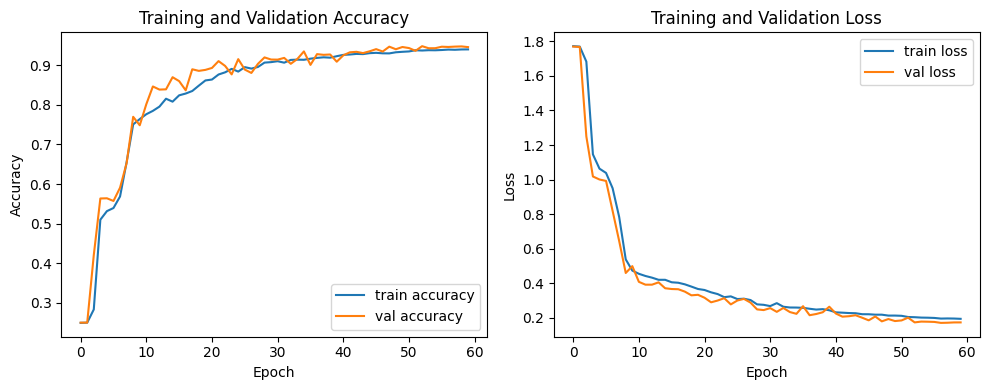

In [8]:
# Train
start_time = time.time()
history_cs = model_cs.fit(
    train_ds_cs,
    validation_data=val_ds_cs,
    epochs=60,
    callbacks=cbs
)
duration = time.time() - start_time
print(f"Training completed in {duration:.2f} seconds ({duration/60:.2f} minutes)")

# Plot Accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cs.history['accuracy'], label='train accuracy')
plt.plot(history_cs.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_cs.history['loss'], label='train loss')
plt.plot(history_cs.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


=== Evaluating on Test Set ===
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 120ms/step - accuracy: 0.9656 - loss: 0.1057

Test Set performance → Loss: 0.1847, Accuracy: 0.9392


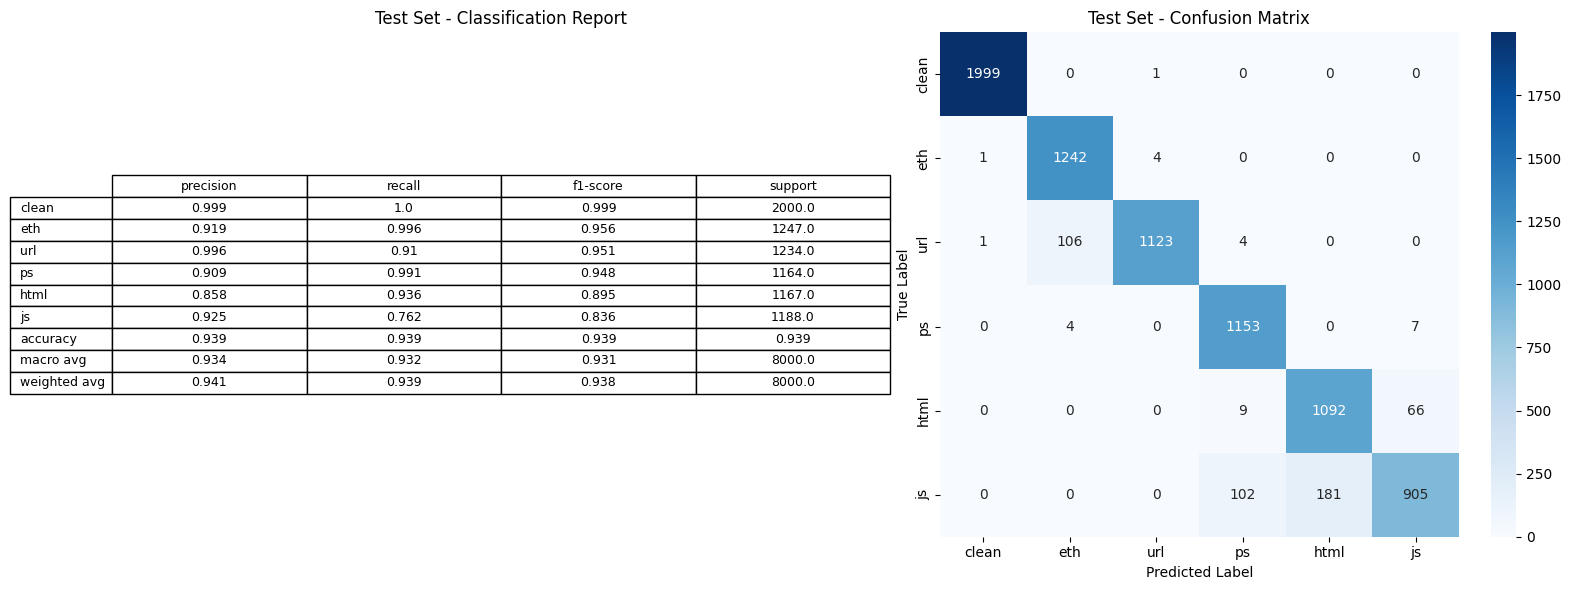

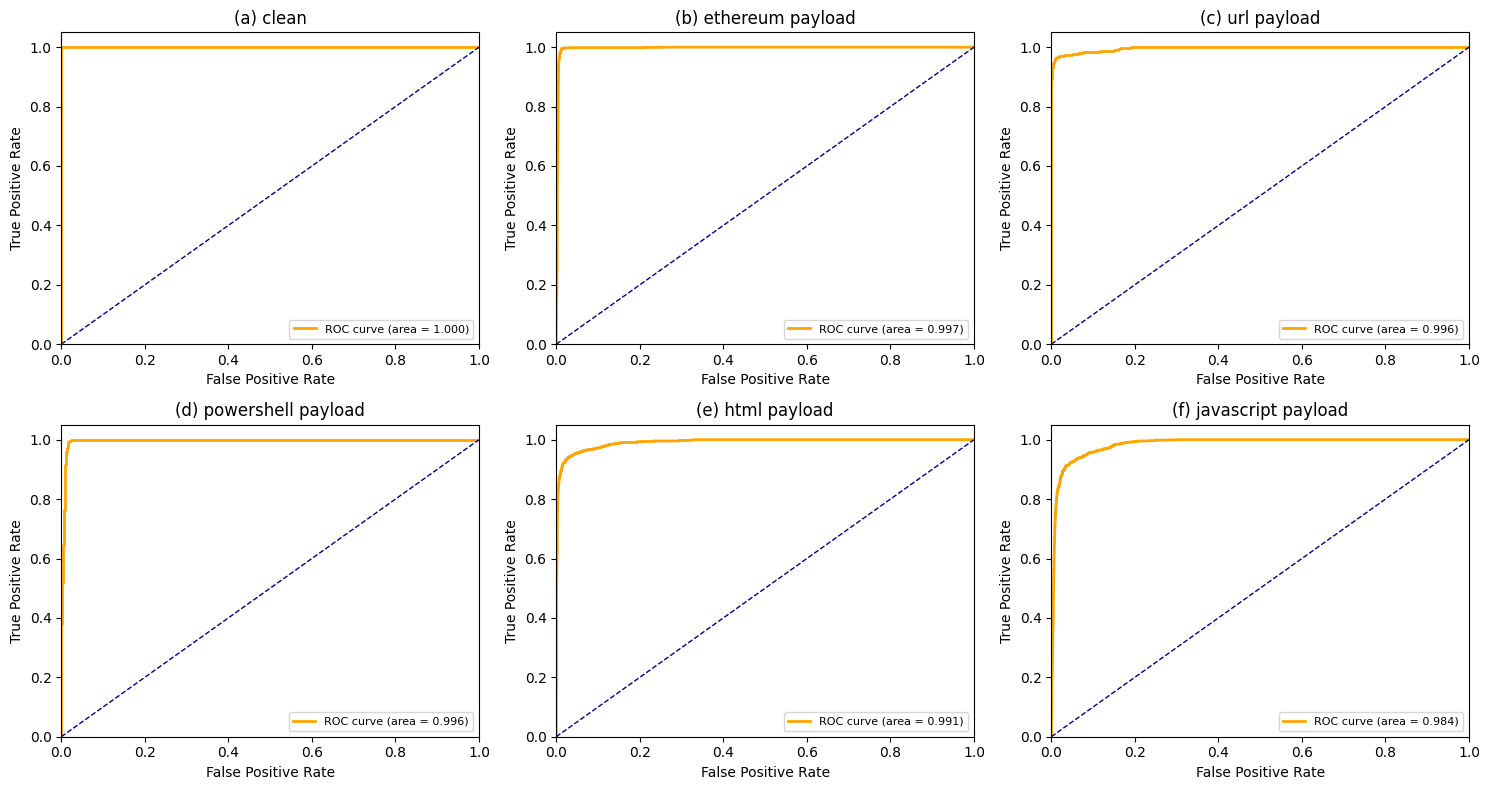


=== Evaluating on Base64 Set ===
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.8915 - loss: 0.2797

Base64 Set performance → Loss: 0.5121, Accuracy: 0.7970


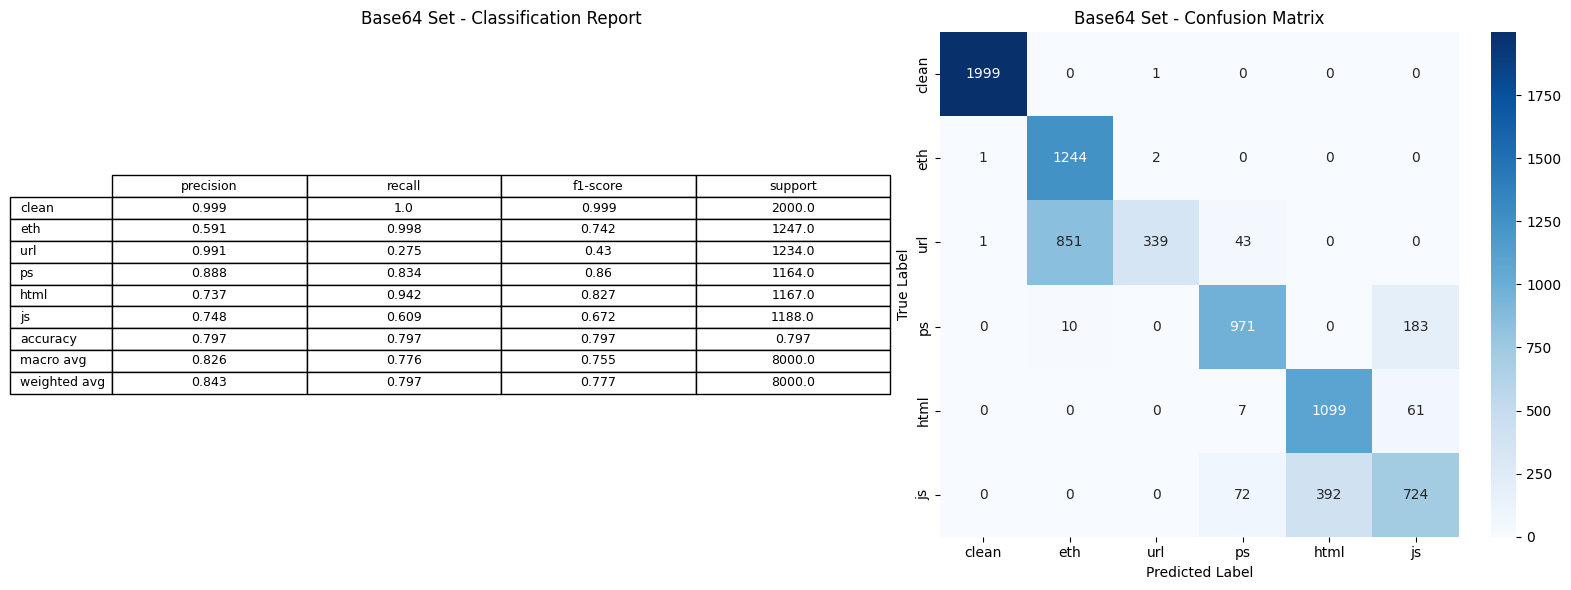

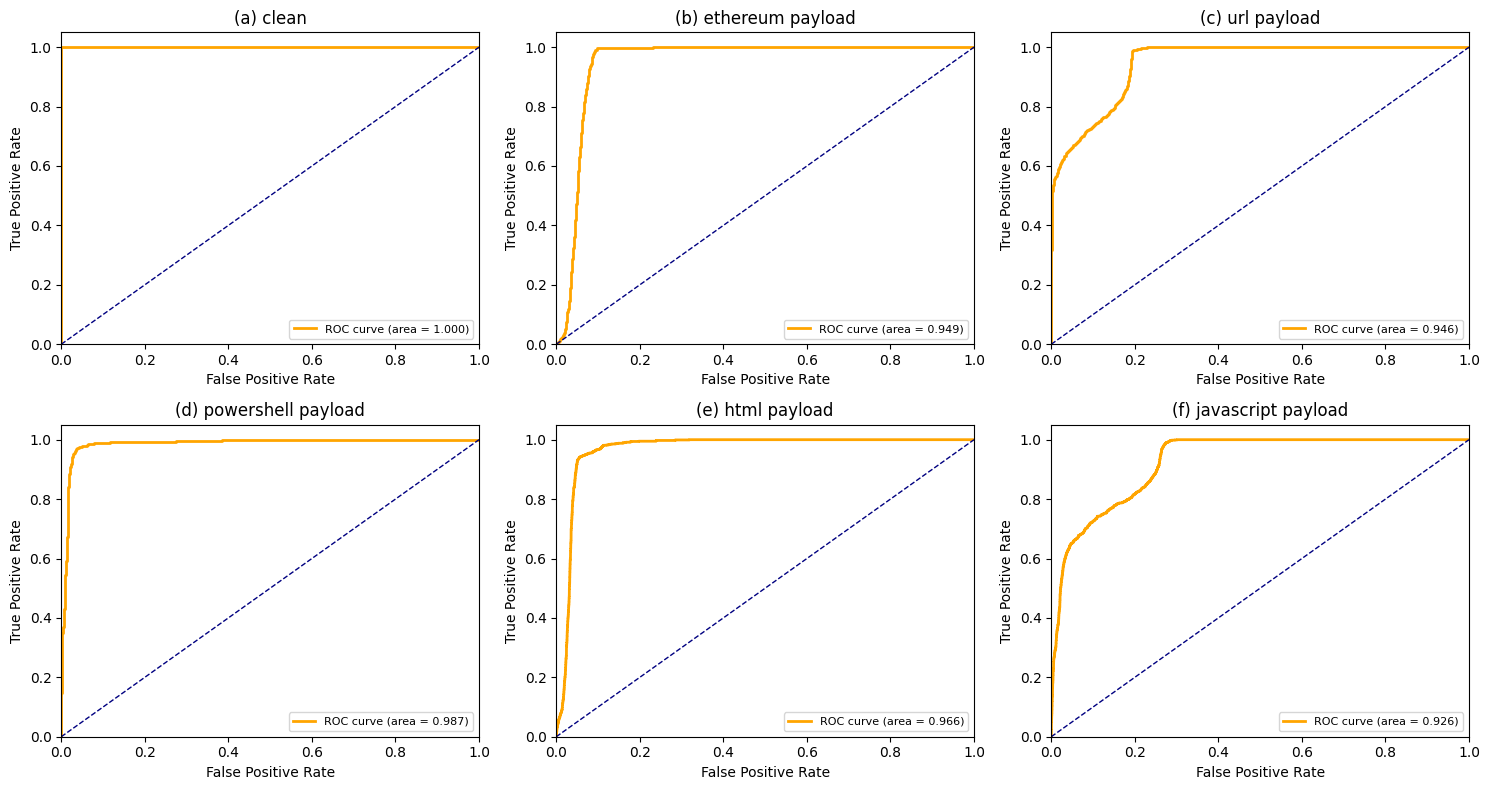


=== Evaluating on Zip Set ===
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 162ms/step - accuracy: 0.7909 - loss: 2.7965

Zip Set performance → Loss: 5.1606, Accuracy: 0.6112


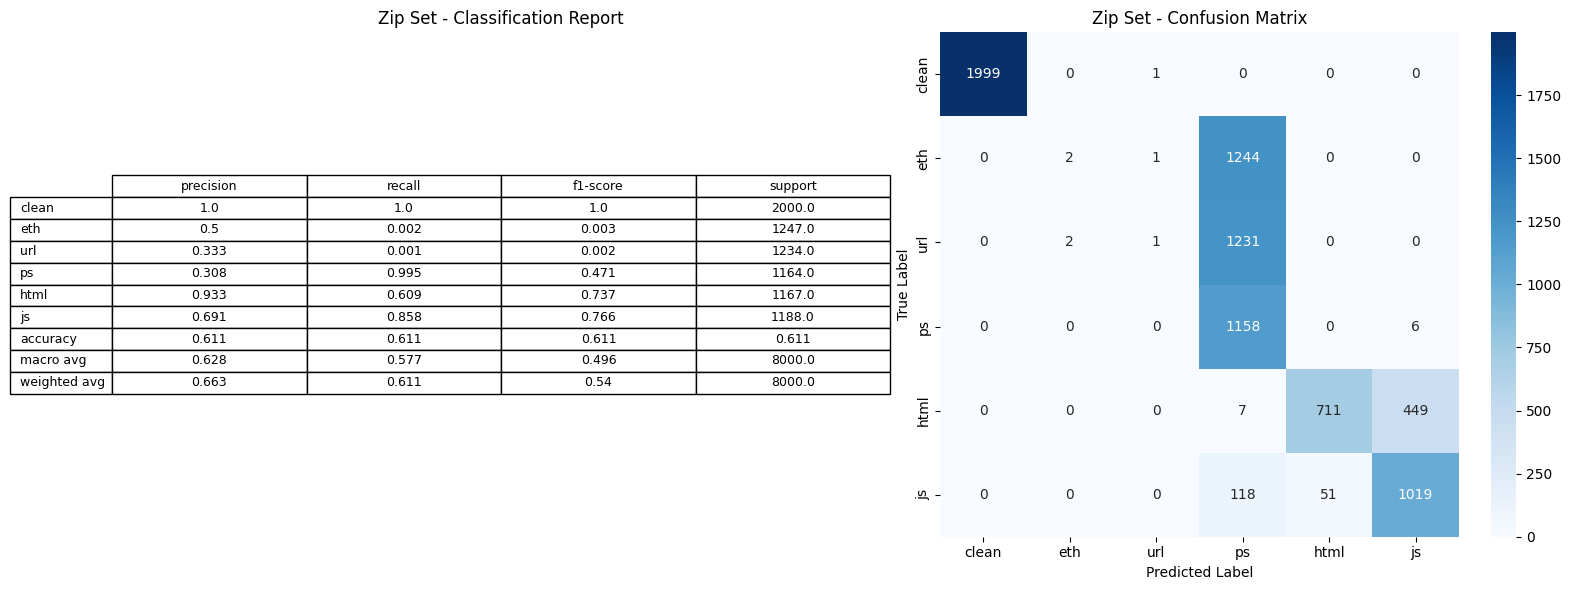

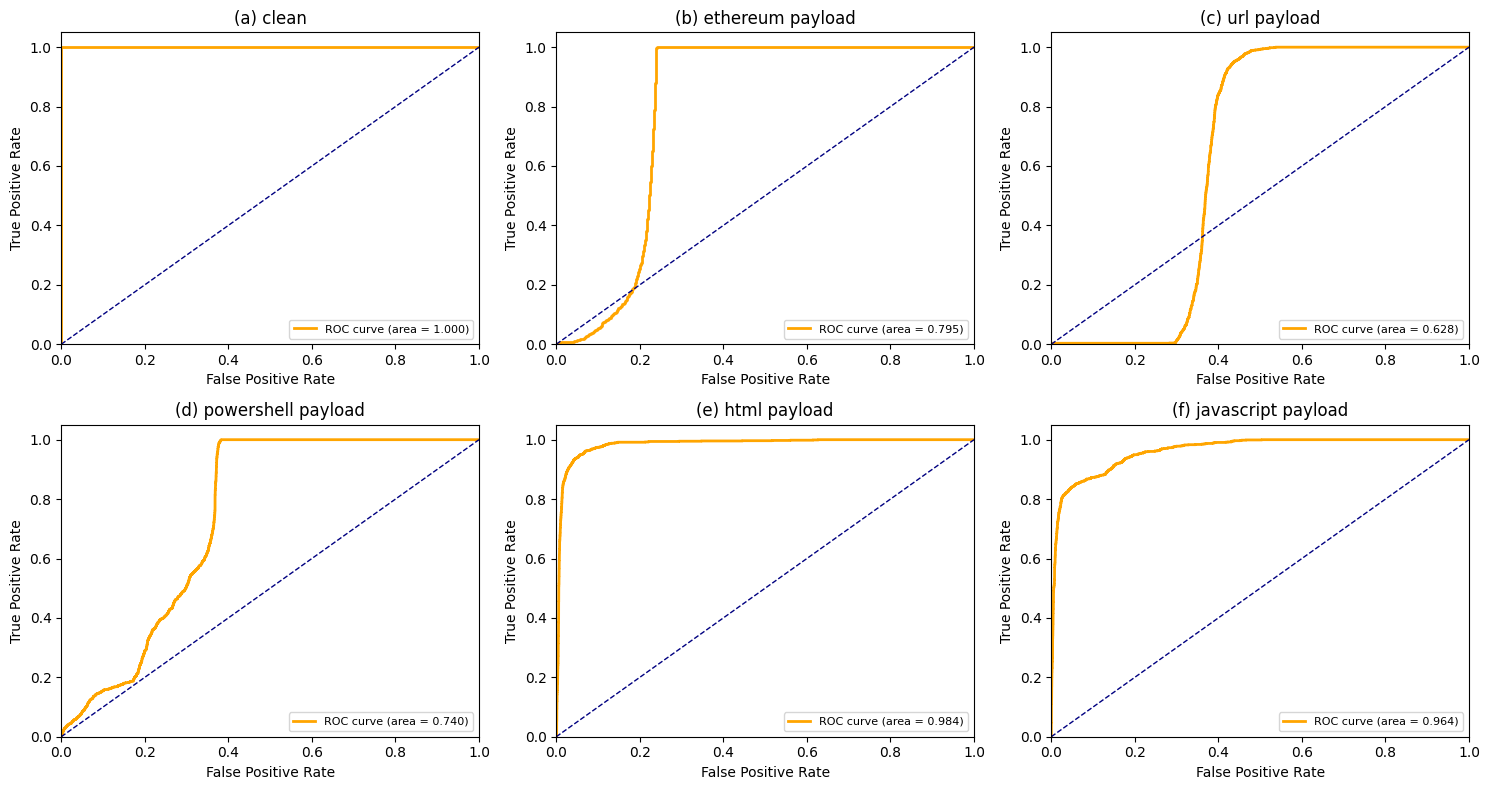

In [19]:
datasets = [
    ("Test Set",   test_ds_cs),
    ("Base64 Set", base64_ds_cs),
    ("Zip Set",    zip_ds_cs),
]

metrics_results = {}

for name, ds in datasets:
    print(f"\n=== Evaluating on {name} ===")
    metrics_results[name] = evaluate_multiclass_model(model_cs, ds, label_map_cs, class_names, dataset_name=name, verbose=1)

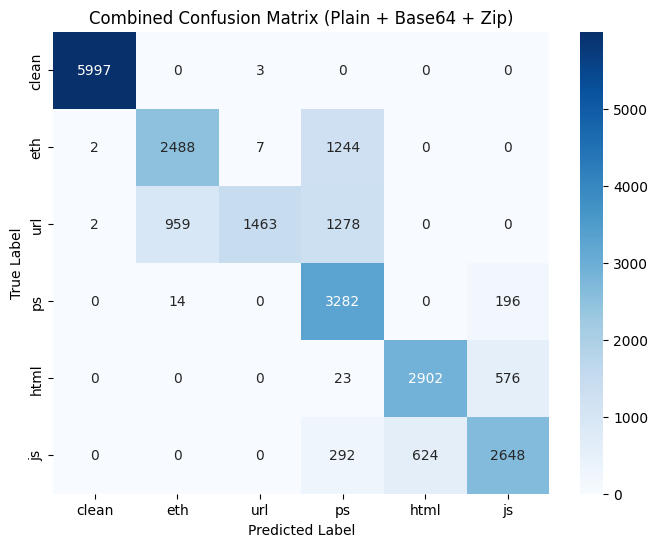

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plain = np.array([
    [1999, 0,   1,   0,    0,    0],
    [1,    1242, 4,   0,    0,    0],
    [1,    106,  1123, 4,    0,    0],
    [0,    4,    0,   1153, 0,    7],
    [0,    0,    0,   9,    1092, 66],
    [0,    0,    0,   102,  181,  905]
])

base64 = np.array([
    [1999, 0,   1,   0,    0,    0],
    [1,    1244, 2, 0,    0,    0],
    [1,    851,  339,  43,   0,    0],
    [0,    10,    0,   971, 0,    183],
    [0,    0,    0,   7,    1099, 61],
    [0,    0,    0,   72,   392,  724]
])

zip_mtx = np.array([
    [1999, 0,   1,   0,    0,    0],
    [0,    2,   1,   1244, 0,    0],
    [0,    2,   1,   1231, 0,    0],
    [0,    0,    0,   1158, 0,    6],
    [0,    0,    0,   7,    711, 449],
    [0,    0,    0,   118,  51,  1019]
])

total_confusion = plain + base64 + zip_mtx

labels = ["clean", "eth", "url", "ps", "html", "js"]

plt.figure(figsize=(8, 6))
sns.heatmap(total_confusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Combined Confusion Matrix (Plain + Base64 + Zip)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


# Transfer Learning

## Freeze layer 0-5

In [23]:
# 1. Load model hasil training binary classification
model_bin = build_mini_vgg(input_shape=(256,256,4))
model_bin.load_weights('/kaggle/working/mini_vgg_hp_bin.keras')

# 2. Panggil dummy input agar .input dan .output terbentuk
dummy_input = tf.zeros((1, 256, 256, 4))
_ = model_bin(dummy_input)

# 3. Bekukan layer Conv2D sampai conv2d_5
for layer in model_bin.layers[:8]:
    layer.trainable = False

# 4. Ambil input & output feature extractor secara aman
base_input = model_bin.layers[0].input            # input layer
base_output = model_bin.layers[-3].output         # output GlobalAveragePooling2D

# 5. Tambahkan head baru untuk klasifikasi payload
dense1 = Dense(128, activation='relu')(base_output)
final_output = Dense(6, activation='softmax')(dense1)

# 6. Bangun model baru
model_cs_transfer = Model(inputs=base_input, outputs=final_output)

# 7. Kompilasi model
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cs_transfer.summary()


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 256, 256, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,582 (1.16 MB)

 Trainable params: 17,286 (67.52 KB)

 Non-trainable params: 287,296 (1.10 MB)

In [24]:
for i, layer in enumerate(model_cs_transfer.layers):
    print(f"{i}: {layer.name} → Trainable: {layer.trainable}")

0: input_layer_3 → Trainable: True
1: conv2d_18 → Trainable: False
2: conv2d_19 → Trainable: False
3: max_pooling2d_9 → Trainable: False
4: conv2d_20 → Trainable: False
5: conv2d_21 → Trainable: False
6: max_pooling2d_10 → Trainable: False
7: conv2d_22 → Trainable: False
8: conv2d_23 → Trainable: False
9: max_pooling2d_11 → Trainable: True
10: global_average_pooling2d_3 → Trainable: True
11: dense_10 → Trainable: True
12: dense_11 → Trainable: True


In [25]:
# Kompilasi
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cbs_transfer = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8, verbose=1),
    ModelCheckpoint('mini_vgg_tl_031025_freeze_0-5.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

Epoch 1/60

Epoch 1: val_loss improved from inf to 1.23741, saving model to mini_vgg_tl_031025_freeze_0-5.keras
500/500 - 94s - 187ms/step - accuracy: 0.3216 - loss: 2.5634 - val_accuracy: 0.4333 - val_loss: 1.2374 - learning_rate: 1.0000e-05
Epoch 2/60

Epoch 2: val_loss improved from 1.23741 to 0.98142, saving model to mini_vgg_tl_031025_freeze_0-5.keras
500/500 - 91s - 181ms/step - accuracy: 0.5344 - loss: 1.1584 - val_accuracy: 0.7229 - val_loss: 0.9814 - learning_rate: 1.0000e-05
Epoch 3/60

Epoch 3: val_loss improved from 0.98142 to 0.88308, saving model to mini_vgg_tl_031025_freeze_0-5.keras
500/500 - 90s - 180ms/step - accuracy: 0.6781 - loss: 0.9888 - val_accuracy: 0.6919 - val_loss: 0.8831 - learning_rate: 1.0000e-05
Epoch 4/60

Epoch 4: val_loss improved from 0.88308 to 0.80369, saving model to mini_vgg_tl_031025_freeze_0-5.keras
500/500 - 90s - 181ms/step - accuracy: 0.6797 - loss: 0.9006 - val_accuracy: 0.7066 - val_loss: 0.8037 - learning_rate: 1.0000e-05
Epoch 5/60

Epoc

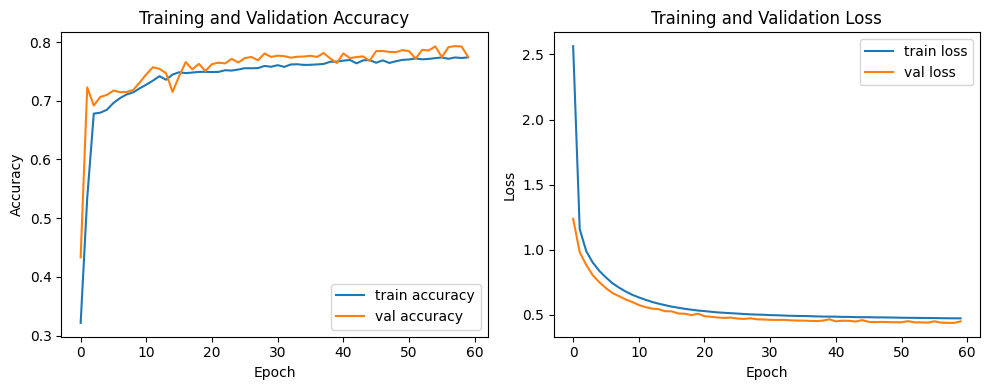

In [26]:
start = time.time()
history_transfer = model_cs_transfer.fit(
    train_ds_cs,               
    validation_data=val_ds_cs,
    epochs=60,
    batch_size=32,
    callbacks=cbs_transfer,
    verbose=2
)
end = time.time()
duration = end - start
print(f"Training completed in {duration:.2f} seconds ({duration/60:.2f} minutes)")

# Plot Accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='train accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='train loss')
plt.plot(history_transfer.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Freeze layer 0-4

In [7]:
# 1. Load model hasil training binary classification
model_bin = build_mini_vgg(input_shape=(256,256,4))
model_bin.load_weights('/kaggle/working/mini_vgg_hp_bin.keras')

# 2. Panggil dummy input agar .input dan .output terbentuk
dummy_input = tf.zeros((1, 256, 256, 4))
_ = model_bin(dummy_input)

# 3. Bekukan layer Conv2D sampai conv2d_5
for layer in model_bin.layers[:7]:
    layer.trainable = False

# 4. Ambil input & output feature extractor secara aman
base_input = model_bin.layers[0].input            # input layer
base_output = model_bin.layers[-3].output         # output GlobalAveragePooling2D

# 5. Tambahkan head baru untuk klasifikasi payload
dense1 = Dense(128, activation='relu')(base_output)
final_output = Dense(6, activation='softmax')(dense1)

# 6. Bangun model baru
model_cs_transfer = Model(inputs=base_input, outputs=final_output)

# 7. Kompilasi model
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cs_transfer.summary()


I0000 00:00:1759540973.453220      36 cuda_dnn.cc:529] Loaded cuDNN version 90300


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,582 (1.16 MB)

 Trainable params: 164,870 (644.02 KB)

 Non-trainable params: 139,712 (545.75 KB)

In [8]:
for i, layer in enumerate(model_cs_transfer.layers):
    print(f"{i}: {layer.name} → Trainable: {layer.trainable}")

0: input_layer → Trainable: True
1: conv2d → Trainable: False
2: conv2d_1 → Trainable: False
3: max_pooling2d → Trainable: False
4: conv2d_2 → Trainable: False
5: conv2d_3 → Trainable: False
6: max_pooling2d_1 → Trainable: False
7: conv2d_4 → Trainable: False
8: conv2d_5 → Trainable: True
9: max_pooling2d_2 → Trainable: True
10: global_average_pooling2d → Trainable: True
11: dense_2 → Trainable: True
12: dense_3 → Trainable: True


In [10]:
# Kompilasi
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cbs_transfer = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8, verbose=1),
    ModelCheckpoint('mini_vgg_tl_031025_freeze_0-4.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

Epoch 1/60


I0000 00:00:1759541015.916441      72 service.cc:148] XLA service 0x78eba000c2b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759541015.917351      72 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759541019.972203      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 1.14109, saving model to mini_vgg_tl_031025_freeze_0-4.keras
500/500 - 120s - 241ms/step - accuracy: 0.3969 - loss: 1.8228 - val_accuracy: 0.6777 - val_loss: 1.1411 - learning_rate: 1.0000e-05
Epoch 2/60

Epoch 2: val_loss improved from 1.14109 to 0.92542, saving model to mini_vgg_tl_031025_freeze_0-4.keras
500/500 - 90s - 180ms/step - accuracy: 0.6488 - loss: 1.0562 - val_accuracy: 0.6848 - val_loss: 0.9254 - learning_rate: 1.0000e-05
Epoch 3/60

Epoch 3: val_loss improved from 0.92542 to 0.80916, saving model to mini_vgg_tl_031025_freeze_0-4.keras
500/500 - 90s - 180ms/step - accuracy: 0.6641 - loss: 0.9089 - val_accuracy: 0.7069 - val_loss: 0.8092 - learning_rate: 1.0000e-05
Epoch 4/60

Epoch 4: val_loss improved from 0.80916 to 0.75009, saving model to mini_vgg_tl_031025_freeze_0-4.keras
500/500 - 90s - 181ms/step - accuracy: 0.6715 - loss: 0.8245 - val_accuracy: 0.6726 - val_loss: 0.7501 - learning_rate: 1.0000e-05
Epoch 5/60

Epoch 5: val_l

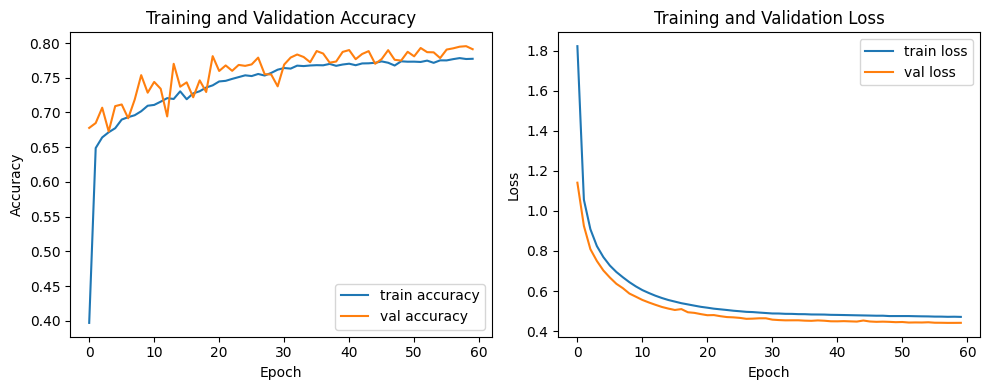

In [11]:
start = time.time()
history_transfer = model_cs_transfer.fit(
    train_ds_cs,               
    validation_data=val_ds_cs,
    epochs=60,
    batch_size=32,
    callbacks=cbs_transfer,
    verbose=2
)
end = time.time()
duration = end - start
print(f"Training completed in {duration:.2f} seconds ({duration/60:.2f} minutes)")

# Plot Accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='train accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='train loss')
plt.plot(history_transfer.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Freeze layer 0-3

In [6]:
# 1. Load model hasil training binary classification
model_bin = build_mini_vgg(input_shape=(256,256,4))
model_bin.load_weights('/kaggle/working/mini_vgg_hp_bin.keras')

# 2. Panggil dummy input agar .input dan .output terbentuk
dummy_input = tf.zeros((1, 256, 256, 4))
_ = model_bin(dummy_input)

# 3. Bekukan layer Conv2D sampai conv2d_5
for layer in model_bin.layers[:6]:
    layer.trainable = False

# 4. Ambil input & output feature extractor secara aman
base_input = model_bin.layers[0].input            # input layer
base_output = model_bin.layers[-3].output         # output GlobalAveragePooling2D

# 5. Tambahkan head baru untuk klasifikasi payload
dense1 = Dense(128, activation='relu')(base_output)
final_output = Dense(6, activation='softmax')(dense1)

# 6. Bangun model baru
model_cs_transfer = Model(inputs=base_input, outputs=final_output)

# 7. Kompilasi model
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cs_transfer.summary()


I0000 00:00:1759547543.054328      36 cuda_dnn.cc:529] Loaded cuDNN version 90300


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,582 (1.16 MB)

 Trainable params: 238,726 (932.52 KB)

 Non-trainable params: 65,856 (257.25 KB)

In [7]:
for i, layer in enumerate(model_cs_transfer.layers):
    print(f"{i}: {layer.name} → Trainable: {layer.trainable}")

0: input_layer → Trainable: True
1: conv2d → Trainable: False
2: conv2d_1 → Trainable: False
3: max_pooling2d → Trainable: False
4: conv2d_2 → Trainable: False
5: conv2d_3 → Trainable: False
6: max_pooling2d_1 → Trainable: False
7: conv2d_4 → Trainable: True
8: conv2d_5 → Trainable: True
9: max_pooling2d_2 → Trainable: True
10: global_average_pooling2d → Trainable: True
11: dense_2 → Trainable: True
12: dense_3 → Trainable: True


In [8]:
# Kompilasi
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cbs_transfer = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8, verbose=1),
    ModelCheckpoint('mini_vgg_tl_031025_freeze_0-3.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

Epoch 1/60


I0000 00:00:1759547594.673114      73 service.cc:148] XLA service 0x781bf800c6c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759547594.673941      73 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759547599.360415      73 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 1.15870, saving model to mini_vgg_tl_031025_freeze_0-3.keras
500/500 - 108s - 216ms/step - accuracy: 0.3222 - loss: 2.4277 - val_accuracy: 0.5286 - val_loss: 1.1587 - learning_rate: 1.0000e-05
Epoch 2/60

Epoch 2: val_loss improved from 1.15870 to 0.87588, saving model to mini_vgg_tl_031025_freeze_0-3.keras
500/500 - 89s - 178ms/step - accuracy: 0.5032 - loss: 1.0899 - val_accuracy: 0.6471 - val_loss: 0.8759 - learning_rate: 1.0000e-05
Epoch 3/60

Epoch 3: val_loss improved from 0.87588 to 0.74489, saving model to mini_vgg_tl_031025_freeze_0-3.keras
500/500 - 89s - 178ms/step - accuracy: 0.6397 - loss: 0.8823 - val_accuracy: 0.6995 - val_loss: 0.7449 - learning_rate: 1.0000e-05
Epoch 4/60

Epoch 4: val_loss improved from 0.74489 to 0.68406, saving model to mini_vgg_tl_031025_freeze_0-3.keras
500/500 - 89s - 178ms/step - accuracy: 0.6721 - loss: 0.7835 - val_accuracy: 0.6881 - val_loss: 0.6841 - learning_rate: 1.0000e-05
Epoch 5/60

Epoch 5: val_l

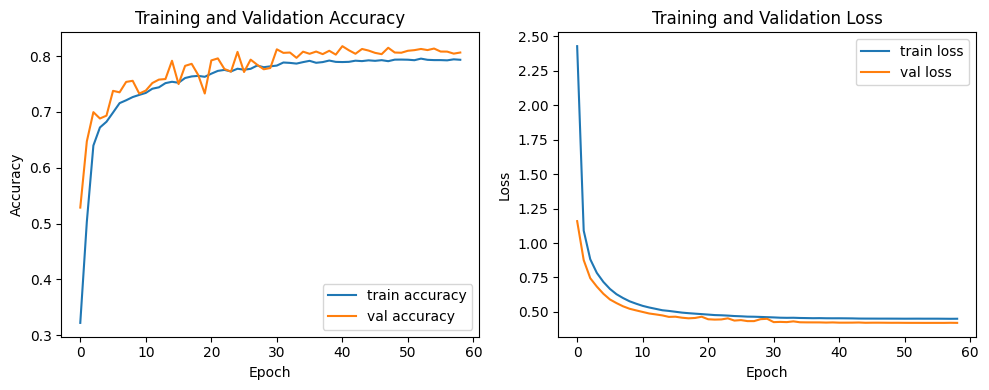

In [9]:
start = time.time()
history_transfer = model_cs_transfer.fit(
    train_ds_cs,               
    validation_data=val_ds_cs,
    epochs=60,
    batch_size=32,
    callbacks=cbs_transfer,
    verbose=2
)
end = time.time()
duration = end - start
print(f"Training completed in {duration:.2f} seconds ({duration/60:.2f} minutes)")

# Plot Accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='train accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='train loss')
plt.plot(history_transfer.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Freeze layer 0-2

In [10]:
# 1. Load model hasil training binary classification
model_bin = build_mini_vgg(input_shape=(256,256,4))
model_bin.load_weights('/kaggle/working/mini_vgg_hp_bin.keras')

# 2. Panggil dummy input agar .input dan .output terbentuk
dummy_input = tf.zeros((1, 256, 256, 4))
_ = model_bin(dummy_input)

# 3. Bekukan layer Conv2D sampai conv2d_5
for layer in model_bin.layers[:4]:
    layer.trainable = False

# 4. Ambil input & output feature extractor secara aman
base_input = model_bin.layers[0].input            # input layer
base_output = model_bin.layers[-3].output         # output GlobalAveragePooling2D

# 5. Tambahkan head baru untuk klasifikasi payload
dense1 = Dense(128, activation='relu')(base_output)
final_output = Dense(6, activation='softmax')(dense1)

# 6. Bangun model baru
model_cs_transfer = Model(inputs=base_input, outputs=final_output)

# 7. Kompilasi model
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cs_transfer.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,582 (1.16 MB)

 Trainable params: 275,654 (1.05 MB)

 Non-trainable params: 28,928 (113.00 KB)

In [11]:
for i, layer in enumerate(model_cs_transfer.layers):
    print(f"{i}: {layer.name} → Trainable: {layer.trainable}")

0: input_layer_1 → Trainable: True
1: conv2d_6 → Trainable: False
2: conv2d_7 → Trainable: False
3: max_pooling2d_3 → Trainable: False
4: conv2d_8 → Trainable: False
5: conv2d_9 → Trainable: True
6: max_pooling2d_4 → Trainable: True
7: conv2d_10 → Trainable: True
8: conv2d_11 → Trainable: True
9: max_pooling2d_5 → Trainable: True
10: global_average_pooling2d_1 → Trainable: True
11: dense_6 → Trainable: True
12: dense_7 → Trainable: True


In [12]:
# Kompilasi
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cbs_transfer = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8, verbose=1),
    ModelCheckpoint('mini_vgg_tl_031025_freeze_0-2.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

Epoch 1/60

Epoch 1: val_loss improved from inf to 1.20793, saving model to mini_vgg_tl_031025_freeze_0-2.keras
500/500 - 95s - 189ms/step - accuracy: 0.3232 - loss: 1.7569 - val_accuracy: 0.4863 - val_loss: 1.2079 - learning_rate: 1.0000e-05
Epoch 2/60

Epoch 2: val_loss improved from 1.20793 to 0.86107, saving model to mini_vgg_tl_031025_freeze_0-2.keras
500/500 - 90s - 181ms/step - accuracy: 0.5261 - loss: 1.0180 - val_accuracy: 0.6112 - val_loss: 0.8611 - learning_rate: 1.0000e-05
Epoch 3/60

Epoch 3: val_loss improved from 0.86107 to 0.74413, saving model to mini_vgg_tl_031025_freeze_0-2.keras
500/500 - 91s - 181ms/step - accuracy: 0.6304 - loss: 0.8273 - val_accuracy: 0.6215 - val_loss: 0.7441 - learning_rate: 1.0000e-05
Epoch 4/60

Epoch 4: val_loss improved from 0.74413 to 0.69526, saving model to mini_vgg_tl_031025_freeze_0-2.keras
500/500 - 90s - 181ms/step - accuracy: 0.6820 - loss: 0.7467 - val_accuracy: 0.6781 - val_loss: 0.6953 - learning_rate: 1.0000e-05
Epoch 5/60

Epoc

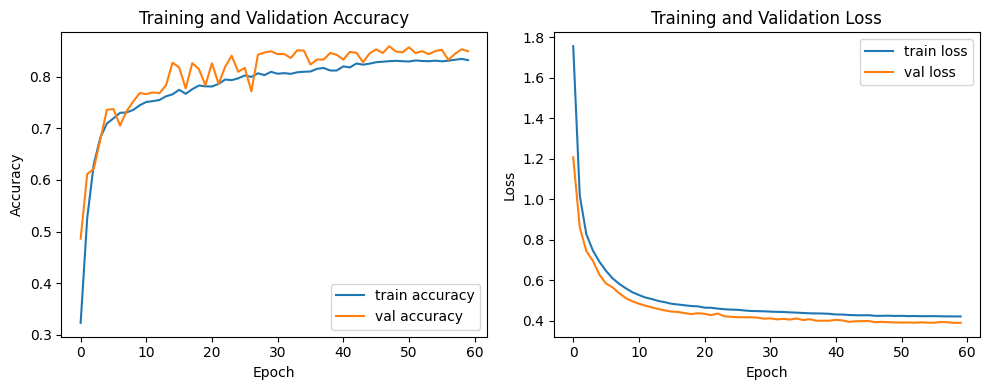

In [13]:
start = time.time()
history_transfer = model_cs_transfer.fit(
    train_ds_cs,               
    validation_data=val_ds_cs,
    epochs=60,
    batch_size=32,
    callbacks=cbs_transfer,
    verbose=2
)
end = time.time()
duration = end - start
print(f"Training completed in {duration:.2f} seconds ({duration/60:.2f} minutes)")

# Plot Accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='train accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='train loss')
plt.plot(history_transfer.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Freeze layer 0-1

In [15]:
# 1. Load model hasil training binary classification
model_bin = build_mini_vgg(input_shape=(256,256,4))
model_bin.load_weights('/kaggle/working/mini_vgg_hp_bin.keras')

# 2. Panggil dummy input agar .input dan .output terbentuk
dummy_input = tf.zeros((1, 256, 256, 4))
_ = model_bin(dummy_input)

# 3. Bekukan layer Conv2D sampai conv2d_5
for layer in model_bin.layers[:3]:
    layer.trainable = False

# 4. Ambil input & output feature extractor secara aman
base_input = model_bin.layers[0].input            # input layer
base_output = model_bin.layers[-3].output         # output GlobalAveragePooling2D

# 5. Tambahkan head baru untuk klasifikasi payload
dense1 = Dense(128, activation='relu')(base_output)
final_output = Dense(6, activation='softmax')(dense1)

# 6. Bangun model baru
model_cs_transfer = Model(inputs=base_input, outputs=final_output)

# 7. Kompilasi model
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cs_transfer.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 256, 256, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,582 (1.16 MB)

 Trainable params: 294,150 (1.12 MB)

 Non-trainable params: 10,432 (40.75 KB)

In [16]:
for i, layer in enumerate(model_cs_transfer.layers):
    print(f"{i}: {layer.name} → Trainable: {layer.trainable}")

0: input_layer_2 → Trainable: True
1: conv2d_12 → Trainable: False
2: conv2d_13 → Trainable: False
3: max_pooling2d_6 → Trainable: False
4: conv2d_14 → Trainable: True
5: conv2d_15 → Trainable: True
6: max_pooling2d_7 → Trainable: True
7: conv2d_16 → Trainable: True
8: conv2d_17 → Trainable: True
9: max_pooling2d_8 → Trainable: True
10: global_average_pooling2d_2 → Trainable: True
11: dense_10 → Trainable: True
12: dense_11 → Trainable: True


In [17]:
# Kompilasi
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cbs_transfer = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8, verbose=1),
    ModelCheckpoint('mini_vgg_tl_031025_freeze_0-1.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

Epoch 1/60

Epoch 1: val_loss improved from inf to 1.26049, saving model to mini_vgg_tl_031025_freeze_0-1.keras
500/500 - 111s - 222ms/step - accuracy: 0.4189 - loss: 1.5918 - val_accuracy: 0.4476 - val_loss: 1.2605 - learning_rate: 1.0000e-05
Epoch 2/60

Epoch 2: val_loss improved from 1.26049 to 0.82467, saving model to mini_vgg_tl_031025_freeze_0-1.keras
500/500 - 102s - 204ms/step - accuracy: 0.5546 - loss: 0.9869 - val_accuracy: 0.5724 - val_loss: 0.8247 - learning_rate: 1.0000e-05
Epoch 3/60

Epoch 3: val_loss improved from 0.82467 to 0.69108, saving model to mini_vgg_tl_031025_freeze_0-1.keras
500/500 - 90s - 181ms/step - accuracy: 0.6678 - loss: 0.7675 - val_accuracy: 0.7081 - val_loss: 0.6911 - learning_rate: 1.0000e-05
Epoch 4/60

Epoch 4: val_loss improved from 0.69108 to 0.61550, saving model to mini_vgg_tl_031025_freeze_0-1.keras
500/500 - 92s - 184ms/step - accuracy: 0.7045 - loss: 0.6813 - val_accuracy: 0.7275 - val_loss: 0.6155 - learning_rate: 1.0000e-05
Epoch 5/60

Ep

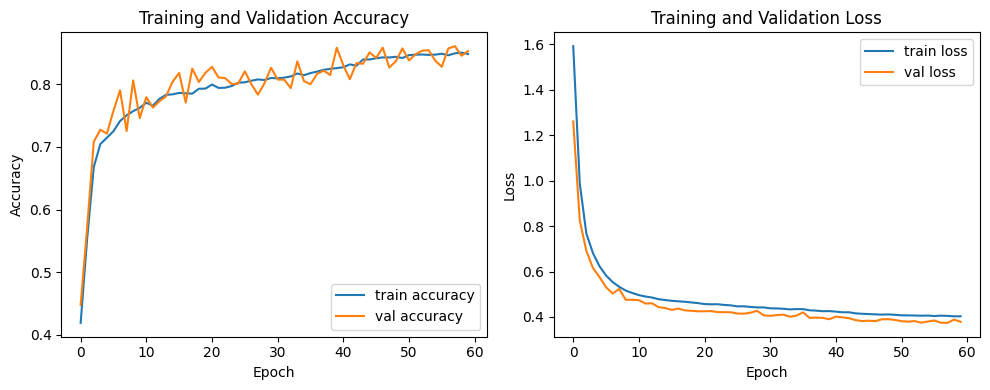

In [18]:
start = time.time()
history_transfer = model_cs_transfer.fit(
    train_ds_cs,               
    validation_data=val_ds_cs,
    epochs=60,
    batch_size=32,
    callbacks=cbs_transfer,
    verbose=2
)
end = time.time()
duration = end - start
print(f"Training completed in {duration:.2f} seconds ({duration/60:.2f} minutes)")

# Plot Accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='train accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='train loss')
plt.plot(history_transfer.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Freeze layer 0

In [7]:
# 1. Load model hasil training binary classification
model_bin = build_mini_vgg(input_shape=(256,256,4))
model_bin.load_weights('/kaggle/working/mini_vgg_hp_bin.keras')

# 2. Panggil dummy input agar .input dan .output terbentuk
dummy_input = tf.zeros((1, 256, 256, 4))
_ = model_bin(dummy_input)

# 3. Bekukan layer Conv2D sampai conv2d_5
for layer in model_bin.layers[:1]:
    layer.trainable = False

# 4. Ambil input & output feature extractor secara aman
base_input = model_bin.layers[0].input            # input layer
base_output = model_bin.layers[-3].output         # output GlobalAveragePooling2D

# 5. Tambahkan head baru untuk klasifikasi payload
dense1 = Dense(128, activation='relu')(base_output)
final_output = Dense(6, activation='softmax')(dense1)

# 6. Bangun model baru
model_cs_transfer = Model(inputs=base_input, outputs=final_output)

# 7. Kompilasi model
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cs_transfer.summary()


I0000 00:00:1759575252.787910      36 cuda_dnn.cc:529] Loaded cuDNN version 90300


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,582 (1.16 MB)

 Trainable params: 303,398 (1.16 MB)

 Non-trainable params: 1,184 (4.62 KB)

In [8]:
for i, layer in enumerate(model_cs_transfer.layers):
    print(f"{i}: {layer.name} → Trainable: {layer.trainable}")

0: input_layer → Trainable: True
1: conv2d → Trainable: False
2: conv2d_1 → Trainable: True
3: max_pooling2d → Trainable: True
4: conv2d_2 → Trainable: True
5: conv2d_3 → Trainable: True
6: max_pooling2d_1 → Trainable: True
7: conv2d_4 → Trainable: True
8: conv2d_5 → Trainable: True
9: max_pooling2d_2 → Trainable: True
10: global_average_pooling2d → Trainable: True
11: dense_2 → Trainable: True
12: dense_3 → Trainable: True


In [10]:
# Kompilasi
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cbs_transfer = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8, verbose=1),
    ModelCheckpoint('mini_vgg_tl_031025_freeze_0.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

Epoch 1/60


I0000 00:00:1759575298.334166      72 service.cc:148] XLA service 0x22c10900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759575298.334816      72 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759575306.688300      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 1.80070, saving model to mini_vgg_tl_031025_freeze_0.keras
500/500 - 129s - 258ms/step - accuracy: 0.1599 - loss: 2.3123 - val_accuracy: 0.2501 - val_loss: 1.8007 - learning_rate: 1.0000e-05
Epoch 2/60

Epoch 2: val_loss improved from 1.80070 to 1.05173, saving model to mini_vgg_tl_031025_freeze_0.keras
500/500 - 90s - 180ms/step - accuracy: 0.3817 - loss: 1.4887 - val_accuracy: 0.4869 - val_loss: 1.0517 - learning_rate: 1.0000e-05
Epoch 3/60

Epoch 3: val_loss improved from 1.05173 to 0.73393, saving model to mini_vgg_tl_031025_freeze_0.keras
500/500 - 90s - 180ms/step - accuracy: 0.6344 - loss: 0.8619 - val_accuracy: 0.6628 - val_loss: 0.7339 - learning_rate: 1.0000e-05
Epoch 4/60

Epoch 4: val_loss improved from 0.73393 to 0.64172, saving model to mini_vgg_tl_031025_freeze_0.keras
500/500 - 90s - 180ms/step - accuracy: 0.6879 - loss: 0.7039 - val_accuracy: 0.6925 - val_loss: 0.6417 - learning_rate: 1.0000e-05
Epoch 5/60

Epoch 5: val_loss impr

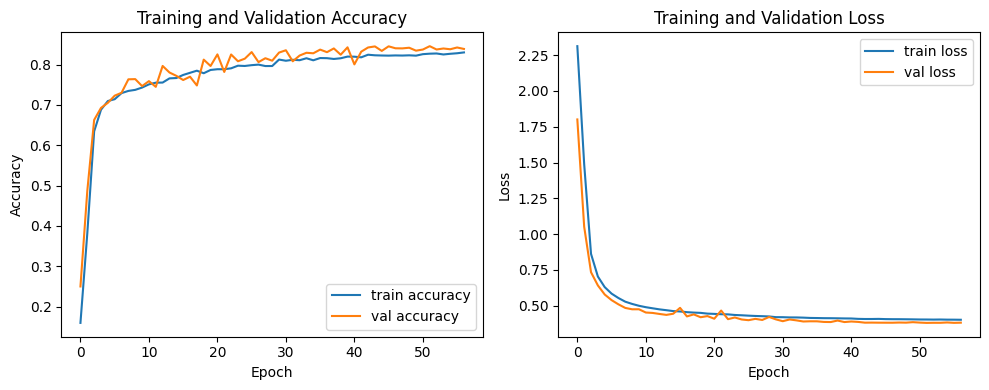

In [11]:
start = time.time()
history_transfer = model_cs_transfer.fit(
    train_ds_cs,               
    validation_data=val_ds_cs,
    epochs=60,
    batch_size=32,
    callbacks=cbs_transfer,
    verbose=2
)
end = time.time()
duration = end - start
print(f"Training completed in {duration:.2f} seconds ({duration/60:.2f} minutes)")

# Plot Accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='train accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='train loss')
plt.plot(history_transfer.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Unfreeze all layers

In [12]:
# 1. Load model hasil training binary classification
model_bin = build_mini_vgg(input_shape=(256,256,4))
model_bin.load_weights('/kaggle/working/mini_vgg_hp_bin.keras')

# 2. Panggil dummy input agar .input dan .output terbentuk
dummy_input = tf.zeros((1, 256, 256, 4))
_ = model_bin(dummy_input)

# 3. Ambil input & output feature extractor secara aman
base_input = model_bin.layers[0].input            # input layer
base_output = model_bin.layers[-3].output         # output GlobalAveragePooling2D

# 4. Tambahkan head baru untuk klasifikasi payload
dense1 = Dense(128, activation='relu')(base_output)
final_output = Dense(6, activation='softmax')(dense1)

# 5. Bangun model baru
model_cs_transfer = Model(inputs=base_input, outputs=final_output)

# 6. Kompilasi model
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cs_transfer.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,582 (1.16 MB)

 Trainable params: 304,582 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
for i, layer in enumerate(model_cs_transfer.layers):
    print(f"{i}: {layer.name} → Trainable: {layer.trainable}")

0: input_layer_1 → Trainable: True
1: conv2d_6 → Trainable: True
2: conv2d_7 → Trainable: True
3: max_pooling2d_3 → Trainable: True
4: conv2d_8 → Trainable: True
5: conv2d_9 → Trainable: True
6: max_pooling2d_4 → Trainable: True
7: conv2d_10 → Trainable: True
8: conv2d_11 → Trainable: True
9: max_pooling2d_5 → Trainable: True
10: global_average_pooling2d_1 → Trainable: True
11: dense_6 → Trainable: True
12: dense_7 → Trainable: True


In [14]:
# Kompilasi
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cbs_transfer = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8, verbose=1),
    ModelCheckpoint('mini_vgg_tl_031025_unfreeze_all.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

Epoch 1/60

Epoch 1: val_loss improved from inf to 1.65754, saving model to mini_vgg_tl_031025_unfreeze_all.keras
500/500 - 96s - 193ms/step - accuracy: 0.2411 - loss: 2.0323 - val_accuracy: 0.2909 - val_loss: 1.6575 - learning_rate: 1.0000e-05
Epoch 2/60

Epoch 2: val_loss improved from 1.65754 to 0.96651, saving model to mini_vgg_tl_031025_unfreeze_all.keras
500/500 - 92s - 184ms/step - accuracy: 0.4392 - loss: 1.3420 - val_accuracy: 0.6495 - val_loss: 0.9665 - learning_rate: 1.0000e-05
Epoch 3/60

Epoch 3: val_loss improved from 0.96651 to 0.76998, saving model to mini_vgg_tl_031025_unfreeze_all.keras
500/500 - 91s - 183ms/step - accuracy: 0.6359 - loss: 0.8666 - val_accuracy: 0.6712 - val_loss: 0.7700 - learning_rate: 1.0000e-05
Epoch 4/60

Epoch 4: val_loss improved from 0.76998 to 0.63895, saving model to mini_vgg_tl_031025_unfreeze_all.keras
500/500 - 91s - 182ms/step - accuracy: 0.6856 - loss: 0.7082 - val_accuracy: 0.6991 - val_loss: 0.6390 - learning_rate: 1.0000e-05
Epoch 5/

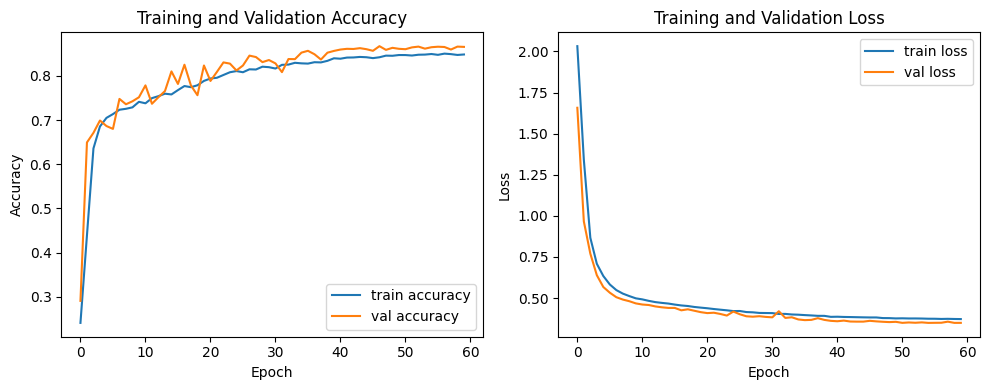

In [15]:
start = time.time()
history_transfer = model_cs_transfer.fit(
    train_ds_cs,               
    validation_data=val_ds_cs,
    epochs=60,
    batch_size=32,
    callbacks=cbs_transfer,
    verbose=2
)
end = time.time()
duration = end - start
print(f"Training completed in {duration:.2f} seconds ({duration/60:.2f} minutes)")

# Plot Accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='train accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='train loss')
plt.plot(history_transfer.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluate the best model


=== Evaluating on Test Set ===


I0000 00:00:1759621377.566890      72 service.cc:148] XLA service 0x7f768c1054d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759621377.567645      72 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759621377.780960      72 cuda_dnn.cc:529] Loaded cuDNN version 90300


  4/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 1.0000 - loss: 0.0025 

I0000 00:00:1759621381.338374      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 142ms/step - accuracy: 0.9205 - loss: 0.2019

Test Set performance → Loss: 0.3669, Accuracy: 0.8545


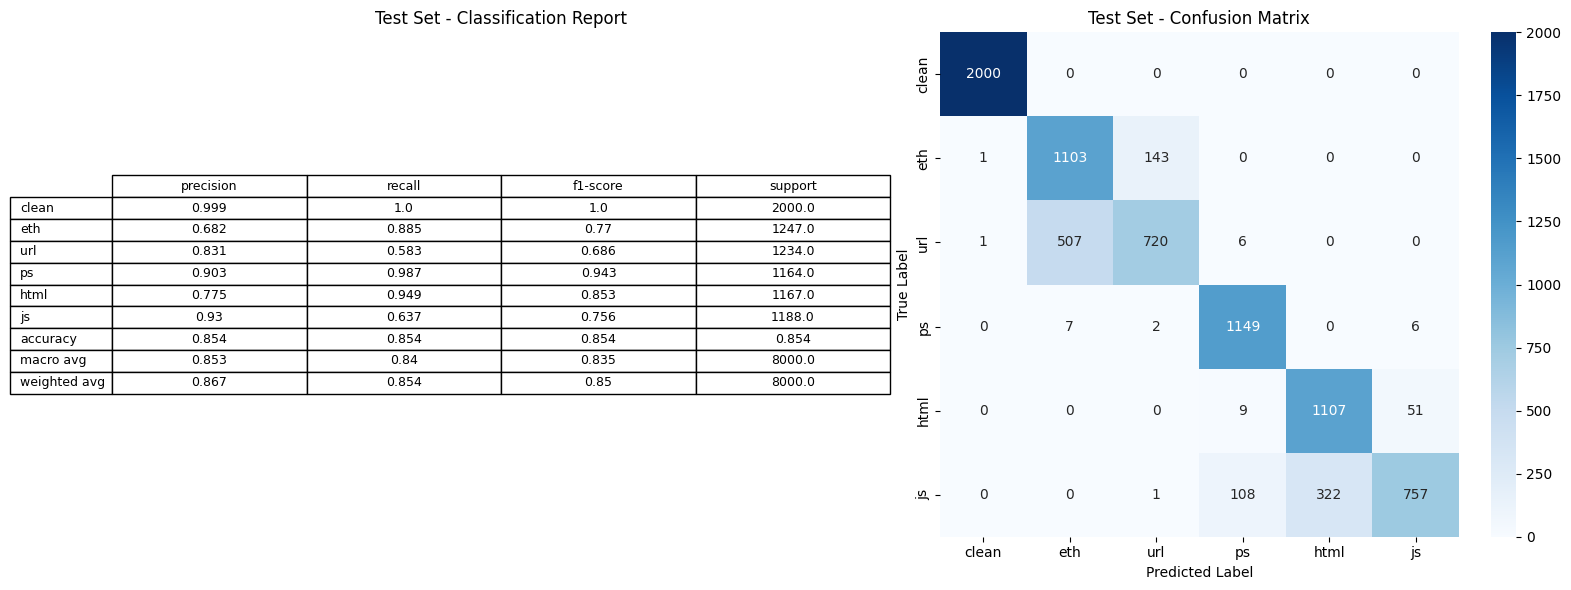

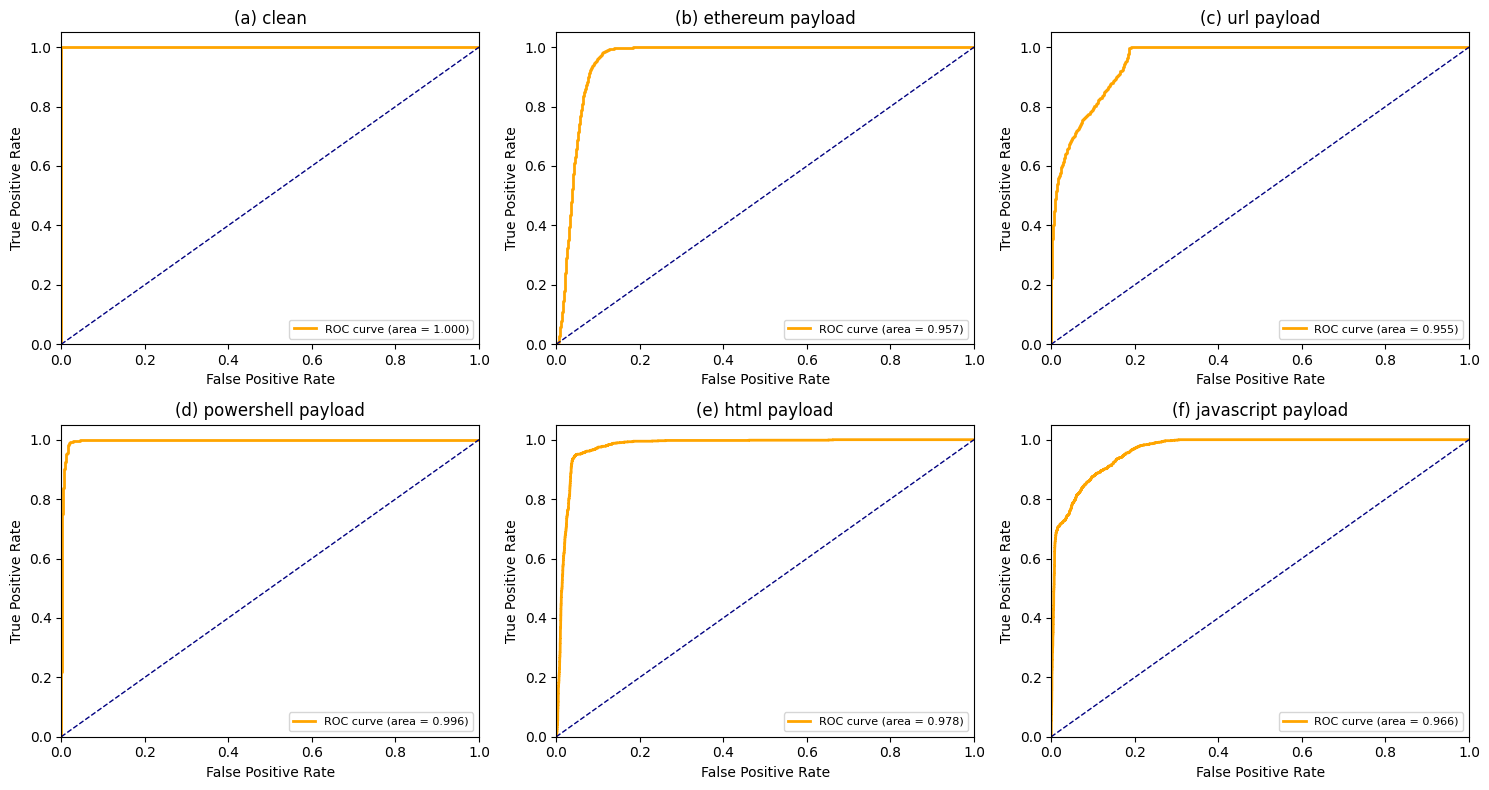


=== Evaluating on Base64 Set ===
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 143ms/step - accuracy: 0.8488 - loss: 0.2664

Base64 Set performance → Loss: 0.4862, Accuracy: 0.7216


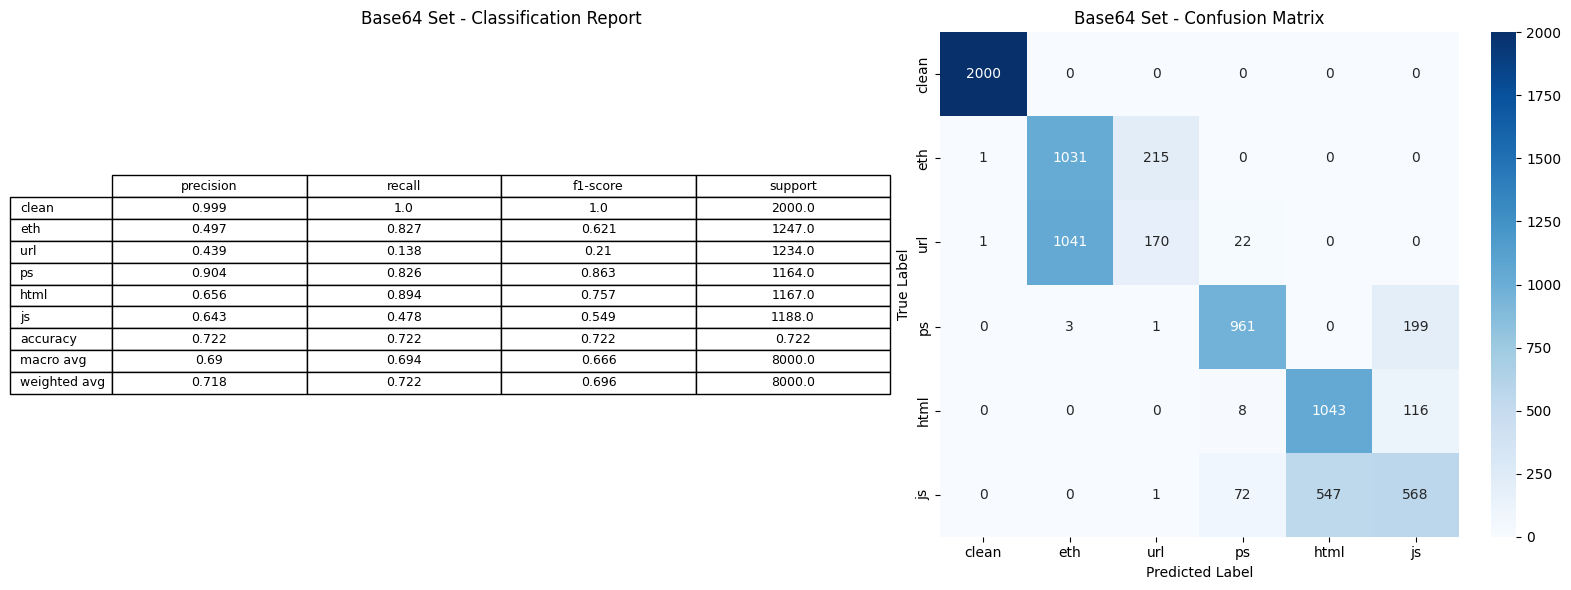

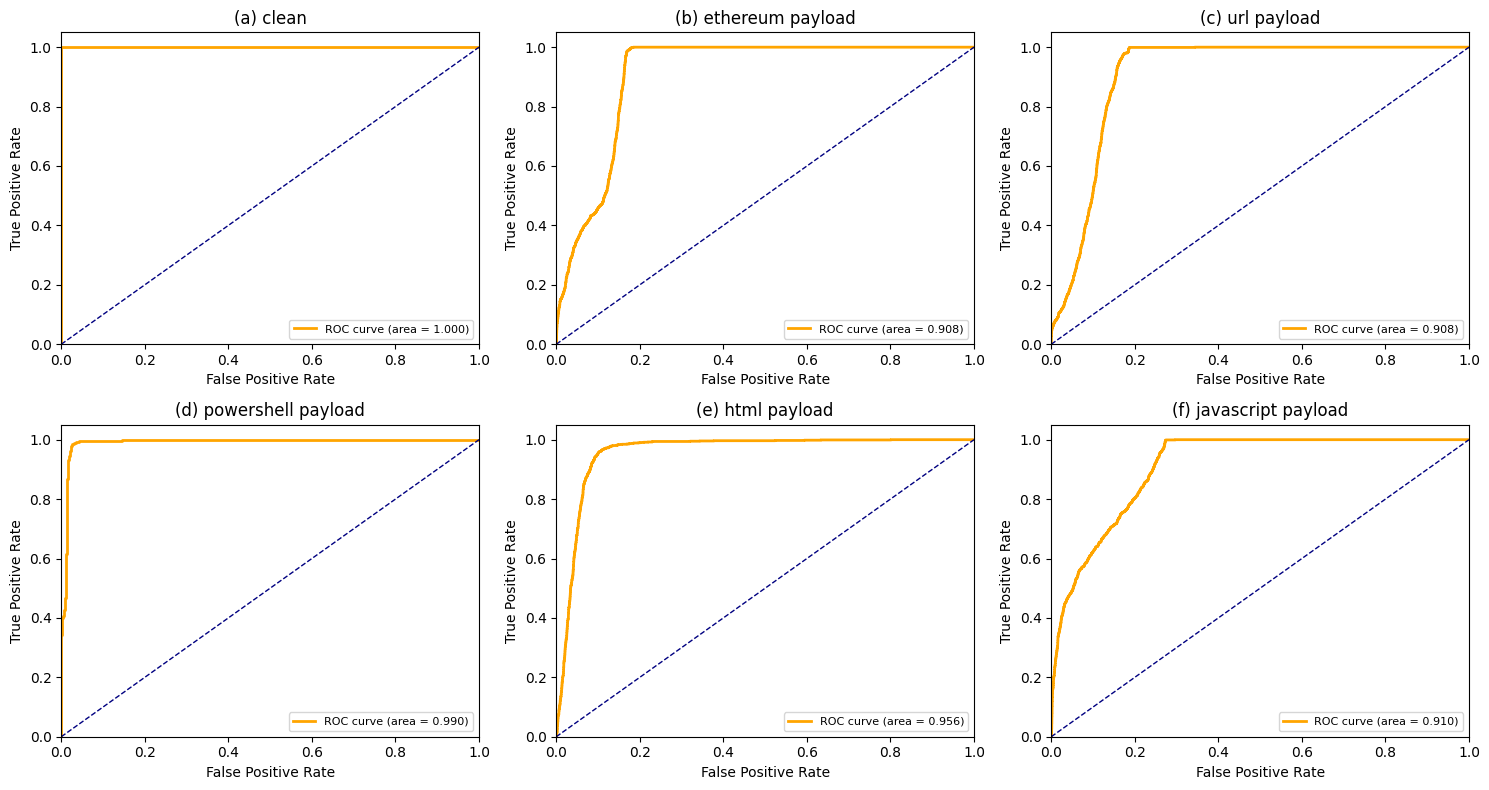


=== Evaluating on Zip Set ===
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 140ms/step - accuracy: 0.7887 - loss: 2.2290

Zip Set performance → Loss: 4.1346, Accuracy: 0.6094


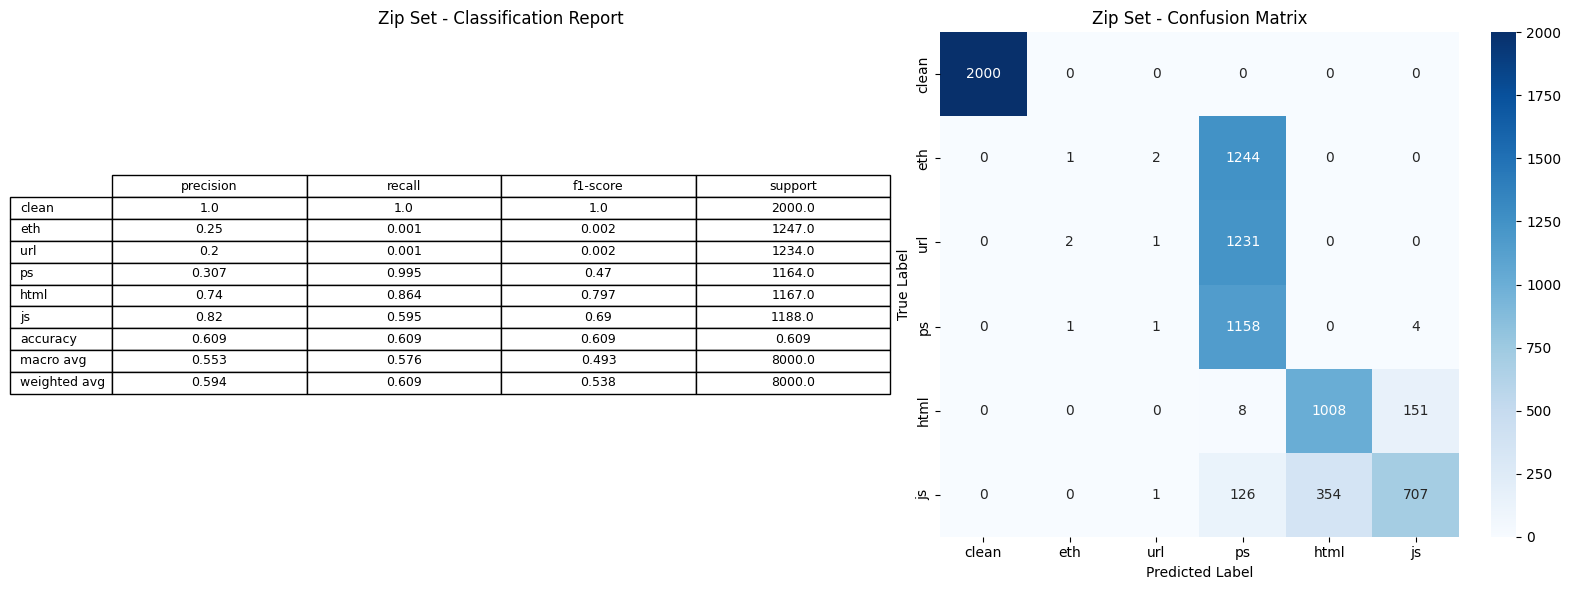

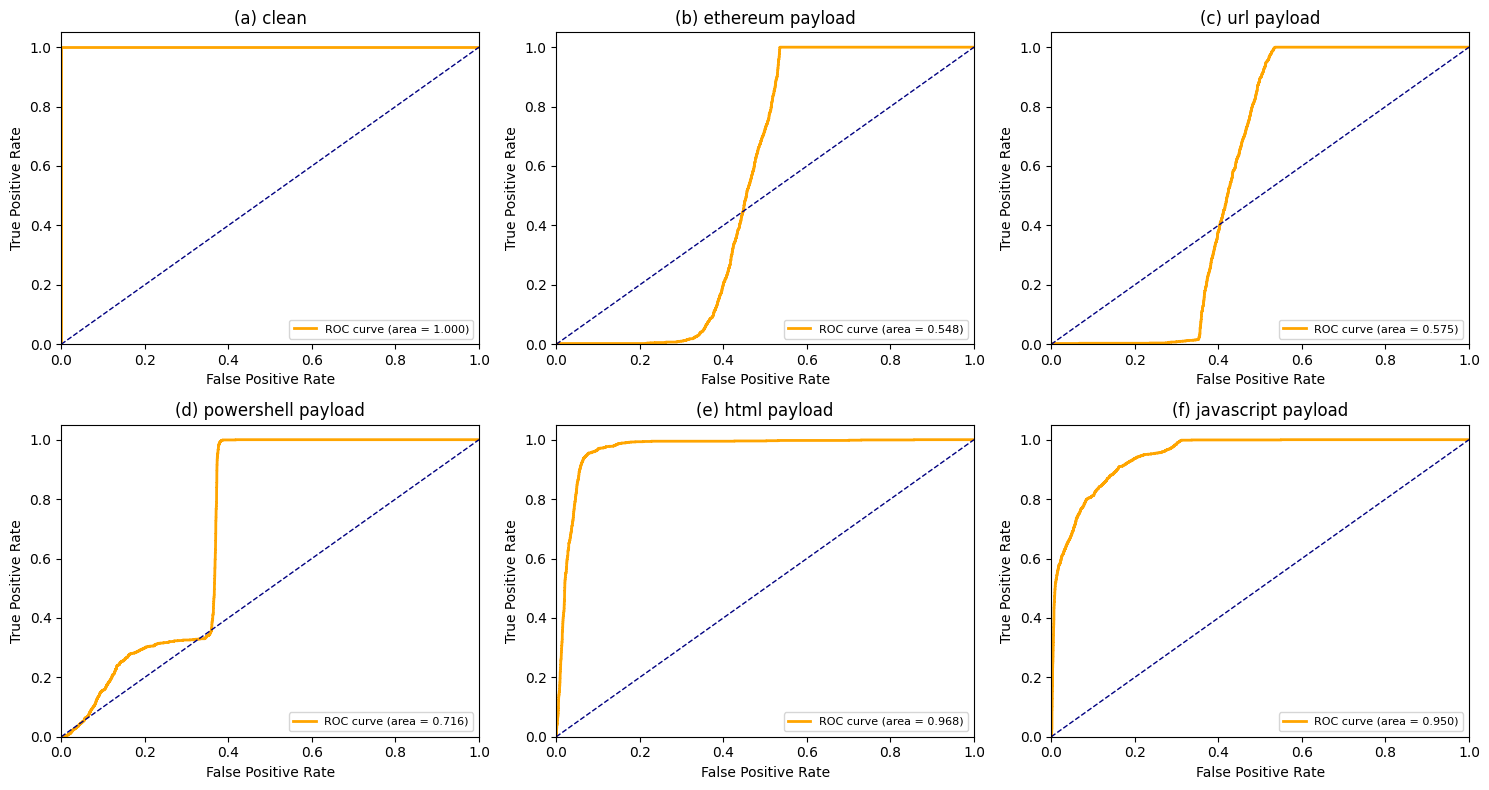

In [7]:
model_cs = tf.keras.models.load_model("/kaggle/working/mini_vgg_tl_031025_unfreeze_all.keras")

datasets = [
    ("Test Set",   test_ds_cs),
    ("Base64 Set", base64_ds_cs),
    ("Zip Set",    zip_ds_cs),
]

metrics_results = {}

for name, ds in datasets:
    print(f"\n=== Evaluating on {name} ===")
    metrics_results[name] = evaluate_multiclass_model(model_cs, ds, label_map_cs, class_names, dataset_name=name, verbose=1)

/tmp/ipykernel_37/1073119767.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels, rotation=45, ha='right')


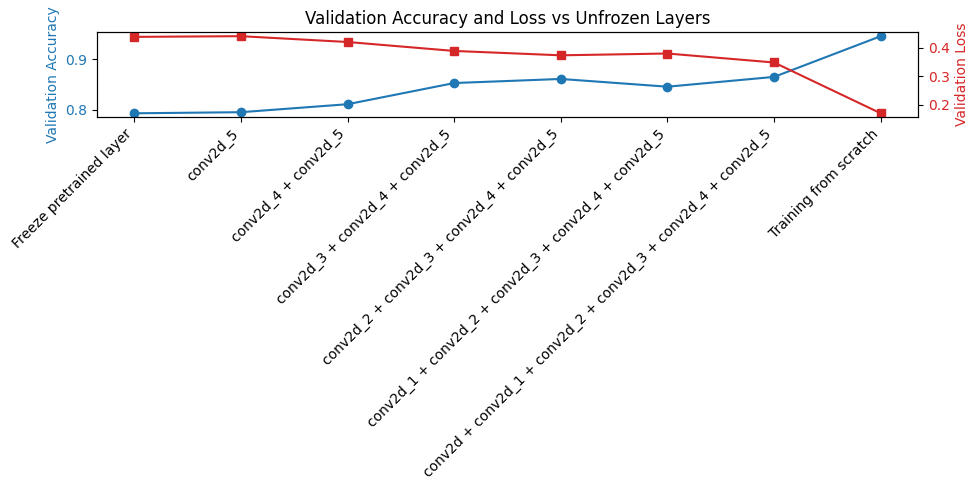

In [8]:
import matplotlib.pyplot as plt

labels = [
    "Freeze pretrained layer",
    "conv2d_5",
    "conv2d_4 + conv2d_5",
    "conv2d_3 + conv2d_4 + conv2d_5",
    "conv2d_2 + conv2d_3 + conv2d_4 + conv2d_5",
    "conv2d_1 + conv2d_2 + conv2d_3 + conv2d_4 + conv2d_5",
    "conv2d + conv2d_1 + conv2d_2 + conv2d_3 + conv2d_4 + conv2d_5",
    "Training from scratch"
]

val_acc = [0.7925, 0.7947, 0.8106, 0.8528, 0.8609, 0.8455, 0.8650, 0.9461]
val_loss = [0.4386, 0.4410, 0.4206, 0.3892, 0.3739, 0.3802, 0.3487, 0.1704]

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(labels, val_acc, marker='o', label='Validation Accuracy', color='tab:blue')
ax1.set_ylabel('Validation Accuracy', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticklabels(labels, rotation=45, ha='right')

ax2 = ax1.twinx()
ax2.plot(labels, val_loss, marker='s', label='Validation Loss', color='tab:red')
ax2.set_ylabel('Validation Loss', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Validation Accuracy and Loss vs Unfrozen Layers')
plt.tight_layout()
plt.show()


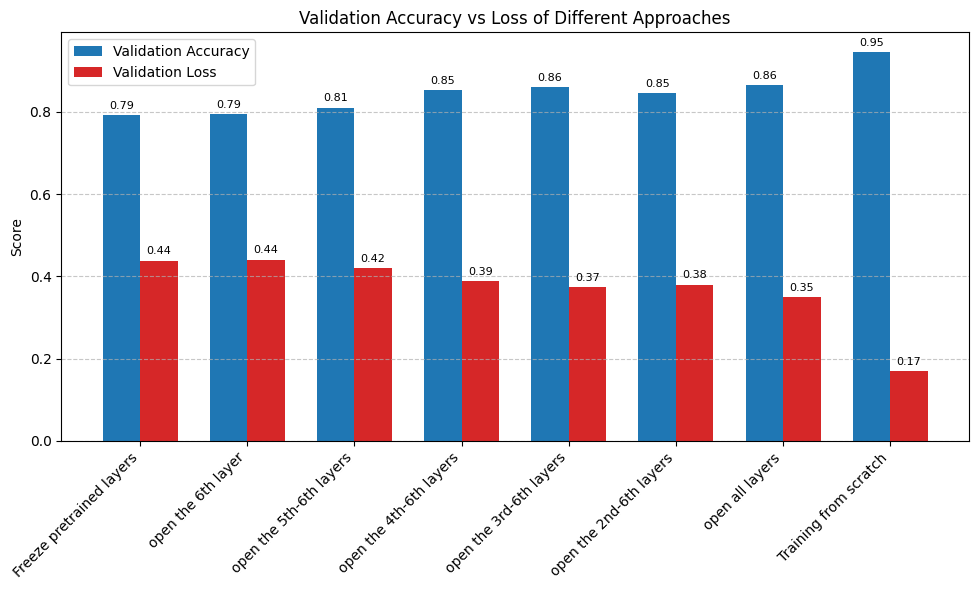

In [12]:
import matplotlib.pyplot as plt
import numpy as np

labels = [
    "Freeze pretrained layers",
    "open the 6th layer",
    "open the 5th-6th layers",
    "open the 4th-6th layers",
    "open the 3rd-6th layers",
    "open the 2nd-6th layers",
    "open all layers",
    "Training from scratch"
]

val_acc = [0.7925, 0.7947, 0.8106, 0.8528, 0.8609, 0.8455, 0.8650, 0.9461]
val_loss = [0.4386, 0.4410, 0.4206, 0.3892, 0.3739, 0.3802, 0.3487, 0.1704]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, val_acc, width, label='Validation Accuracy', color='tab:blue')
bars2 = ax.bar(x + width/2, val_loss, width, label='Validation Loss', color='tab:red')

ax.set_ylabel('Score')
ax.set_title('Validation Accuracy vs Loss of Different Approaches')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()

ax.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', 
            ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()
